In [2]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from scipy import stats

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
int_dir = os.path.join(data_dir,'interim')
fig_dir = os.path.join(proj_dir,'reports','tidal_melting','figures')
tab_dir = os.path.join(proj_dir,'reports','tidal_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

%load_ext autoreload
%autoreload 1
%aimport tools.make_masks

from tools.log_progress import log_progress
from tools.calc_antarctic_mass_loss import calc_antarctic_mass_loss
from tools.make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
from visualization.shiftedColorMap import shiftedColorMap
from tools.rotate_vector_roms import rotate_vector_roms

In [2]:
from dask.distributed import Client
C = Client()
C

<Client: scheduler='tcp://127.0.0.1:43502' processes=16 cores=16>

# annual average tidal melting and changes in ocean temp
## total antarctica

In [4]:
file_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009_avg.nc')
tides = xr.open_dataset(file_path,chunks={'xi_rho':200,'eta_rho':200}).squeeze()

file_path = os.path.join(data_dir,'raw','waom4_nt','ocean_avg_0009_avg.nc')
no_tides = xr.open_dataset(file_path,chunks={'xi_rho':200,'eta_rho':200}).squeeze()

grid_path = os.path.join(int_dir,'grd4_dV.nc')
grd = xr.open_dataset(grid_path)

In [143]:
def plot_ismr_temp_map(m_from,m_to,temp_from,temp_to,grd,
                       temp_str,m_min=-1,m_max=1,t_min=-1,t_max=1,tp_min=-100,tp_max=100,mp_min=-500,mp_max=500,
                       out_path=None):

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    
    m_diff = (m_to-m_from)*s2a
    m_diff_rel = (m_to-m_from)/xr.ufuncs.fabs(m_from)*100
    
    temp_diff = (temp_to-temp_from)
    temp_diff_rel = (temp_to-temp_from)/xr.ufuncs.fabs(temp_from)*100
    
    plt.close()
    fig,axes = plt.subplots(ncols=2,figsize=(25,8))
    ax1,ax2 = axes.flatten()
    for ax in axes:
        ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))
        ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.set_aspect('equal')
        ax.axis('off')

    (m_diff.where(mask))[1:-1,1:-1].plot(vmin=m_min,vmax=m_max,ax=ax1,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate difference in m/yr'})
    temp_diff.squeeze().where(~land_zice)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax1,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference in degC'})
    ax1.set_title('Difference in melt rate (m/yr) and\n'+temp_str+' temperature  (degC)',fontsize=20)
    (m_diff_rel.where(mask))[1:-1,1:-1].plot(vmin=mp_min,vmax=mp_max,ax=ax2,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate relative difference in %'})
    temp_diff_rel.squeeze().where(~land_zice)[1:-1,1:-1].plot(vmin=tp_min,vmax=tp_max,ax=ax2,cmap=ocm.balance,cbar_kwargs={'label':'temperature relative difference in %'})
    ax2.set_title('Relative difference in melt rate and\n'+temp_str+' temperature (%)',fontsize=20)
    
    
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,dpi=300)
    plt.show()

<IPython.core.display.Javascript object>


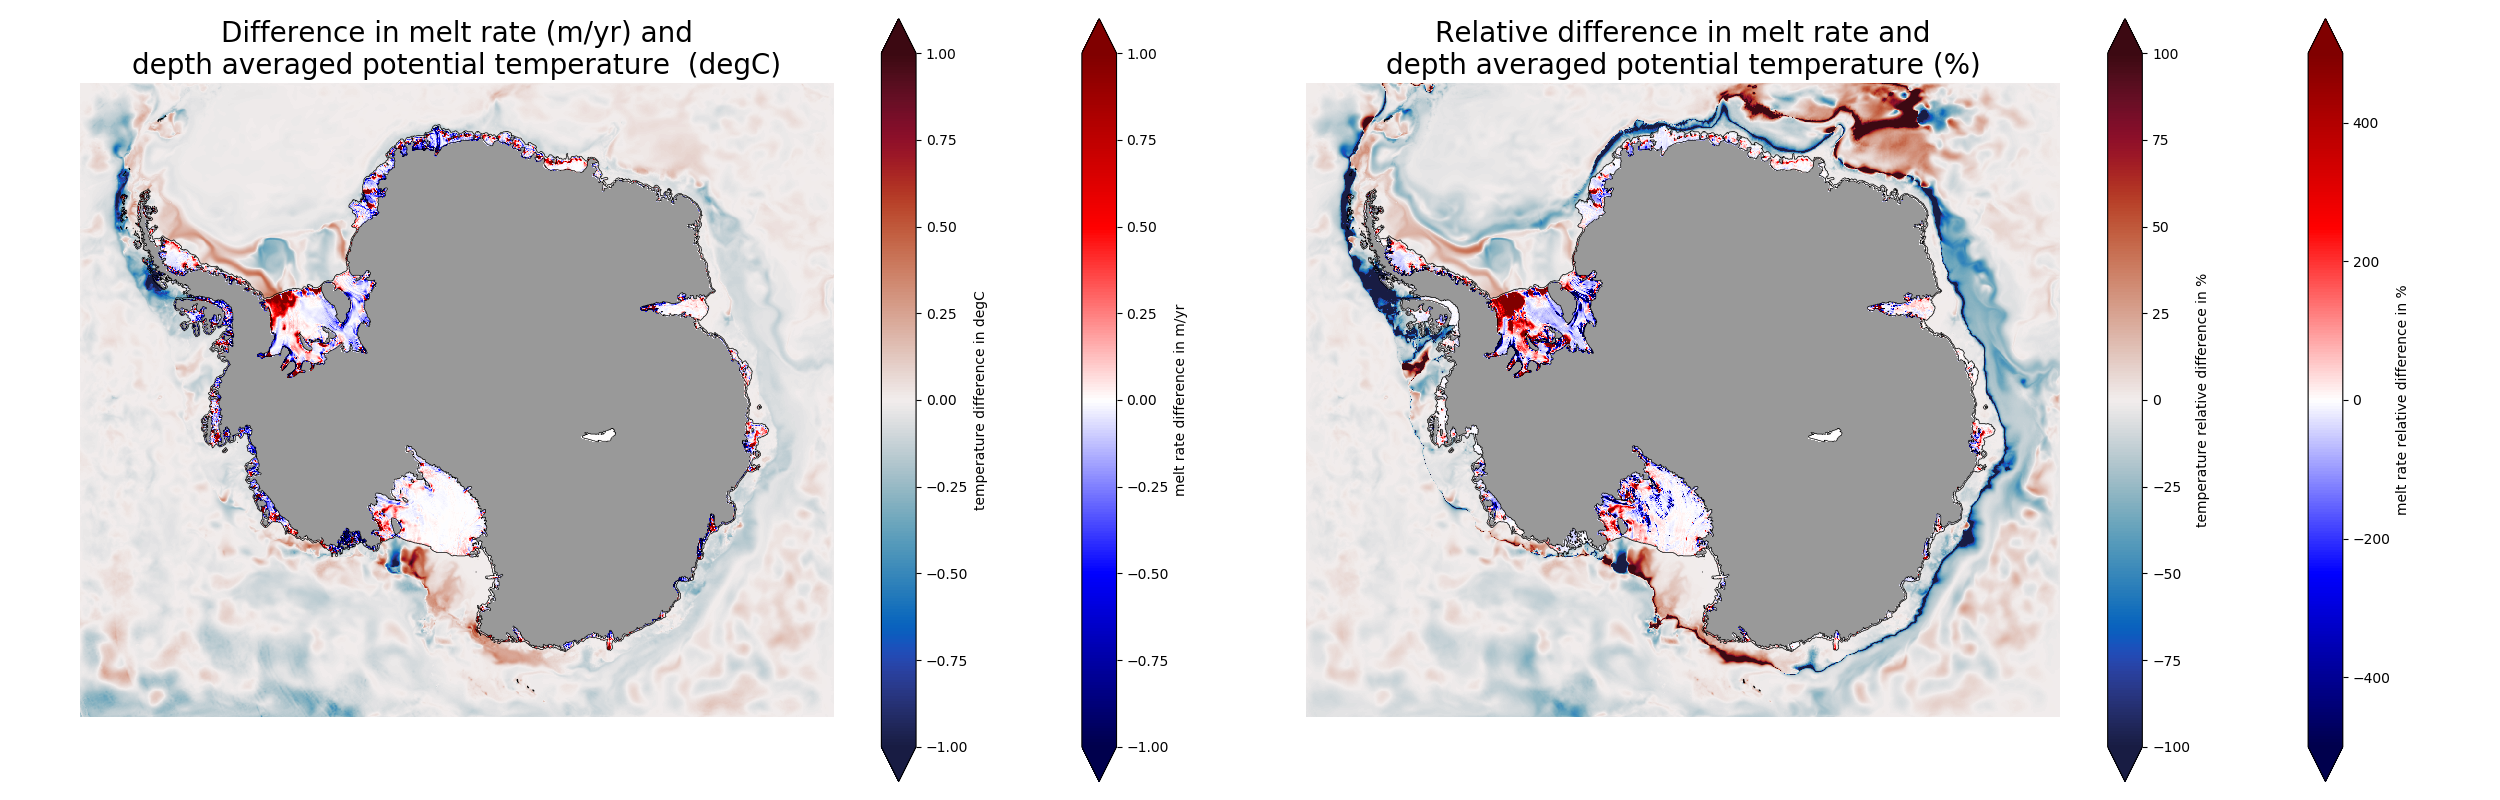

In [145]:
weights = grd.dV/grd.dV.sum('s_rho')
plot_ismr_temp_map(no_tides.m,tides.m,
                   (no_tides.temp*weights).sum('s_rho'),(tides.temp*weights).sum('s_rho'),
                   grd,'depth averaged potential',
                   out_path=os.path.join(fig_dir,'map_Delta_ismr_depth_avg_temp.png'))

In [42]:
calc_antarctic_mass_loss(tides.m-no_tides.m,grd)

Area of all ice shelves in 10^3 km^2:  1690.8425444117381
Area average melt rate in m/yr:  0.036581509390381815
Basal mass loss in Gt/a:  56.65787233310646


In [18]:
mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector) 
weights = grd.dV*mask_shelf['Total Antarctica']/(grd.dV*mask_shelf['Total Antarctica'].sum())
((tides.temp-no_tides.temp)*weights).sum().load()

## sector wise

In [25]:
def calc_mass_loss(m,grd,mask):

    s2a = 3600*24*365.25
    rhoi = 916

    ice_shelf = (grd.mask_rho==1) & (grd.zice<0.0)
    vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)

    mask = ice_shelf & ~vostock & mask

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()

    A = (dA.sum().load())*10**-9
    ismr = (m.where(mask)*weights*s2a).sum().load()
    bmb = (m.where(mask)*dA*rhoi*s2a*10**-12).sum().load()

    #print('Area of all ice shelves in 10^3 km^2: %.2f'%A.values)
    #print('Area average melt rate in m/yr: %.2f'%ismr.values)
    #print('Basal mass loss in Gt/a: %.2f'%bmb.values)
    
    return bmb,ismr,A

In [ ]:
sectors_dict = {}
for k,v in mask_sector.items():
    print('\n'+k)
    bmb,ismr,A = calc_mass_loss(tides.m-no_tides.m,grd,v)
    sectors_dict[k]={}
    sectors_dict[k]['bmb'] = bmb.values
    sectors_dict[k]['ismr'] = ismr.values
    sectors_dict[k]['A'] = A.values

In [50]:
def calc_shelf_temp(temp,grd,mask):
    weights = grd.dV*mask/(grd.dV*mask.sum())
    temp = (temp*weights).sum().load()
    return temp

In [55]:
for k,v in log_progress(mask_shelf.items(),every=2):
    sectors_dict[k]['temp'] = calc_shelf_temp(tides.temp-no_tides.temp,grd,v).values

In [152]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame.from_dict(sectors_dict,orient='index').astype(float)
df = df.rename(index={'George V Coast/Wilkes subglacial basin':'George V Coast',
                 'Sabrina Coast/Aurora subglacial basin':'Sabrina Coast','Amery/Prydz Bay':'Prydz Bay'})
df.to_csv(os.path.join(tab_dir,'sector_Delta_all.csv'))

In [153]:
df = df.loc[['Bellingshausen Sea','Amundsen Sea','Ross Sea','George V Coast','Sabrina Coast','Prydz Bay',
        'Western East Antarctica','Weddell Sea']]

<IPython.core.display.Javascript object>


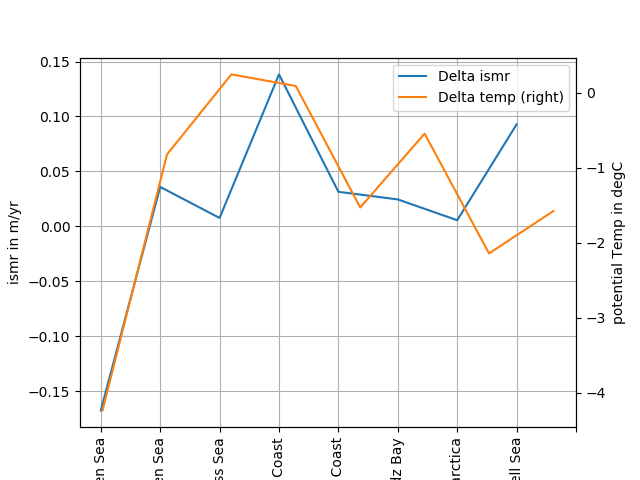

In [154]:
%matplotlib notebook
plt.close()
ax1 = df.plot(y='ismr',label='Delta ismr')
ax2 = df.plot(y='temp',ax=ax1,secondary_y=True,label='Delta temp',xticks=range(9),rot=90)
ax1.set_ylabel('ismr in m/yr')
ax2.set_ylabel('potential Temp in degC')
ax1.grid()
plt.savefig(os.path.join(fig_dir,'sector_Delta_ismrTemp.png'),bbox_inches='tight')
plt.show()

## ice shelf wise

In [4]:
shelves_path = os.path.join(int_dir,'shelves4.npy')
shelves = np.load(shelves_path).item()

In [18]:
for k,v in log_progress(shelves.items(),name='ice shelf'):
    
    bmb,ismr,A = calc_mass_loss(tides.m-no_tides.m,grd,v['mask'])
    
    shelves[k]['Dbmb'] = bmb
    shelves[k]['Dismr'] = ismr
    shelves[k]['DA'] = A
    
    bmb_nt,ismr_nt,A = calc_mass_loss(no_tides.m,grd,v['mask'])
    
    shelves[k]['Dbmb_rel'] = bmb/np.abs(bmb_nt)
    shelves[k]['Dismr_rel'] = ismr/np.abs(ismr_nt)
    
dict_out_path = os.path.join(int_dir,'shelves4.npy')
np.save(dict_out_path,shelves)

In [59]:
shelves_melt = {}
for k,v in shelves.items():
    shelves_melt[k] = {k:v for k,v in v.items() if k in ['bmb','A','ismr','lon_mid','bmb_rel','ismr_rel']}
import pandas as pd
df_shelves = pd.DataFrame.from_dict(shelves_melt,orient='index').astype('float').sort_values('lon_mid')

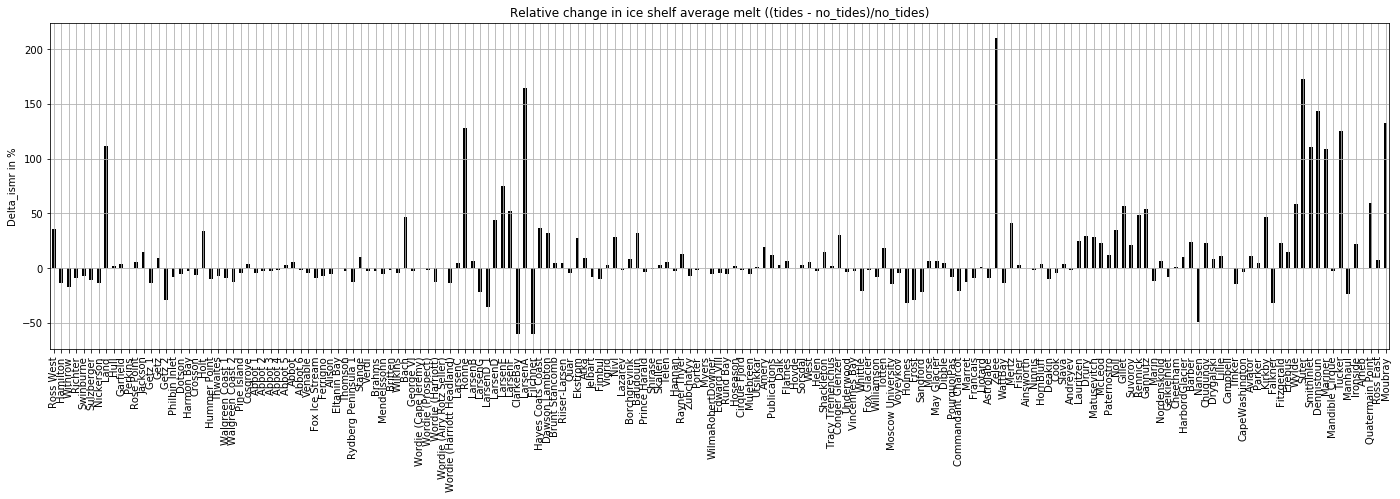

In [65]:
%matplotlib inline
plt.close()
fig,ax = plt.subplots(figsize=(24,6))
(df_shelves.ismr_rel*100).plot.bar(ax=ax,color='k')
ax.grid()
ax.set_ylabel('Delta_ismr in %')
ax.set_title('Relative change in ice shelf average melt ((tides - no_tides)/no_tides)')
plt.savefig(os.path.join(fig_dir,'shelves_all_Delta_ismr_rel.png'),bbox_inches='tight')
plt.show()

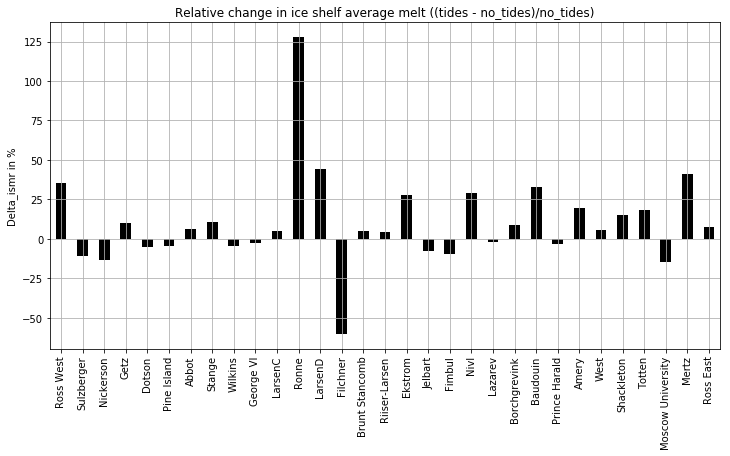

In [67]:
%matplotlib inline
df_big_shelves = df_shelves.loc[df_shelves['A'] >= 5.0]

plt.close()
fig,ax = plt.subplots(figsize=(12,6))
(df_big_shelves.ismr_rel*100).plot.bar(ax=ax,color='k')
ax.grid()
ax.set_ylabel('Delta_ismr in %')
ax.set_title('Relative change in ice shelf average melt ((tides - no_tides)/no_tides)')
plt.savefig(os.path.join(fig_dir,'shelves_big_Delta_ismr_rel.png'),bbox_inches='tight')
plt.show()

In [75]:
plt.rcParams.update({'font.size': 12})
def make_avg_map(quant,grd,shelves_dict):
    shelf_map = np.zeros_like(grd.mask_rho)
    for key,values in log_progress(shelves_dict.items(),every=2):
        shelf_map[values['mask']]=values[quant]
        
    return xr.DataArray(shelf_map,dims=('eta_rho','xi_rho')).where((grd.zice<0)&(grd.mask_rho==1))

def map_shelves_avg(quant,shelves_dict,grd,title,cbar_label,cmap,vrange=None):
    
    avg_map = make_avg_map(quant,grd,shelves_dict)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(10,6))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    if vrange==None:
        #vmin = avg_map.min()
        #vmax = avg_map.max()
        mean = avg_map.mean(dim=avg_map.dims)
        std = avg_map.std(dim=avg_map.dims)
        vmin=max(avg_map.min(),mean-2*std)
        vmax=min(avg_map.max(),mean+2*std)
    else:
        vmin,vmax=vrange
        
    cmap = shiftedColorMap(plt.cm.seismic,midpoint = (1 - vmax/(vmax + abs(vmin))))
    plot = avg_map.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label': cbar_label})
    ax.set_title(title)
    #ax.grid()
    ax.set_ylim([130,1250])
    ax.set_xlim([60,1450])
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,'map_Delta_ismr_shelf_avg.png'),format='png',dpi=300,bbox_inches = "tight")
    plt.show()

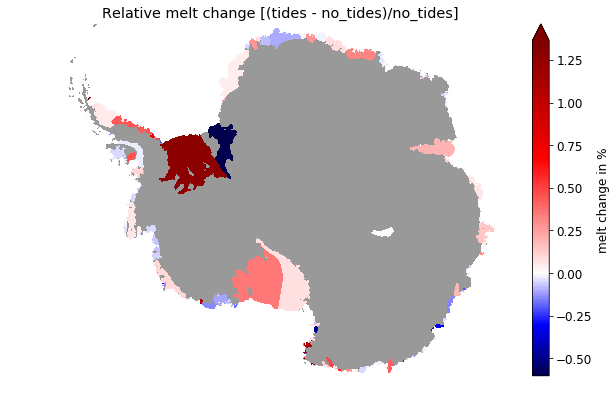

In [106]:
map_shelves_avg('ismr_rel',shelves,grd,'Relative melt change [(tides - no_tides)/no_tides]','melt change in %',plt.cm.seismic)

# Pattern discovery
## Depth and slope

In [231]:
grad_eta = np.zeros_like(grd.mask_rho)
grad_xi = np.zeros_like(grd.mask_rho)

for xi in grd.xi_rho:
    grad_eta[:,xi] = np.gradient(grd.zice[:,xi],np.cumsum(grd.pn[:,xi]**-1))
    
for eta in grd.eta_rho:
    grad_xi[eta,:] = np.gradient(grd.zice[eta,:],np.cumsum(grd.pm[eta,:]**-1))
    
magGradz = np.sqrt(grad_eta**2 + grad_xi**2)
grd['gradZice'] = xr.DataArray(magGradz,dims=('eta_rho','xi_rho'),name='gradzice').where((grd.mask_rho==1)&(grd.zice<0))

<IPython.core.display.Javascript object>


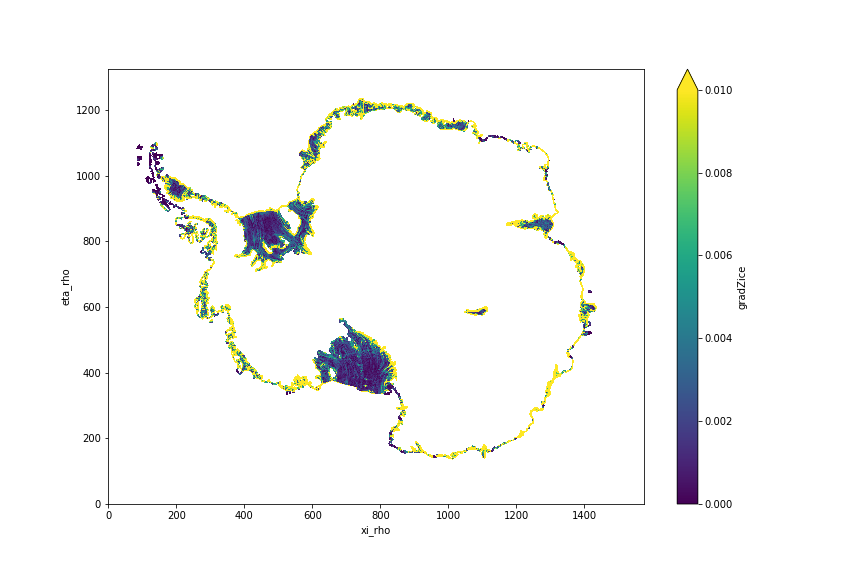

In [236]:
plt.close()
grd.gradZice.plot(size=8,vmax=0.01)

In [65]:
s2a=3600*24*365.25

def scatter(x_quant,xlab,title,xlim=False,ylim=False,save=False, mask = (grd.mask_rho==1) & (grd.zice < 0.0)):
    
    y = (tides.m-no_tides.m).values[mask]*s2a
    x = x_quant.values[mask]

    plt.close()
    fig,ax = plt.subplots(figsize=(10,8))
    plt.plot(x,y,'k.',ms=0.5)
    plt.xlabel(xlab)
    plt.ylabel('ismr in m/yr')
    plt.title(title)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    if save:
        plt.savefig(os.path.join(fig_dir,'scatter_'+title.replace(' ','_')+'.png'),dpi=300)
    plt.show()

<IPython.core.display.Javascript object>


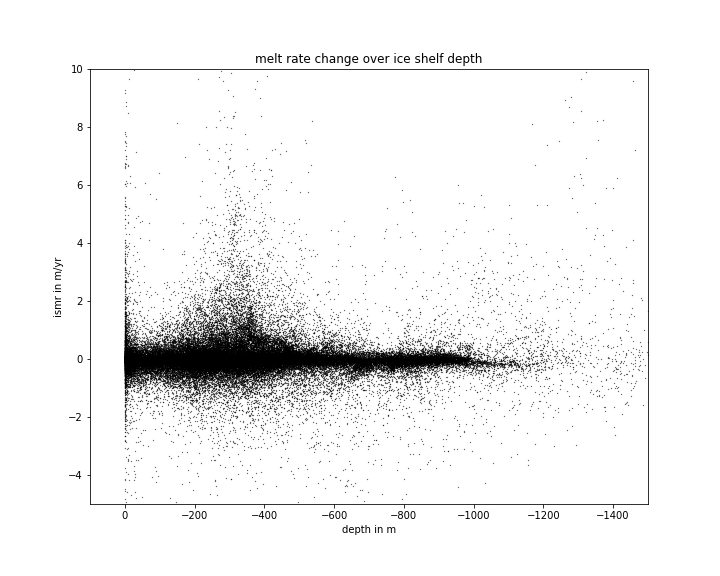

In [245]:
scatter(grd.zice,'depth in m','melt rate change over ice shelf depth',(100,-1500),(-5,10))

<IPython.core.display.Javascript object>


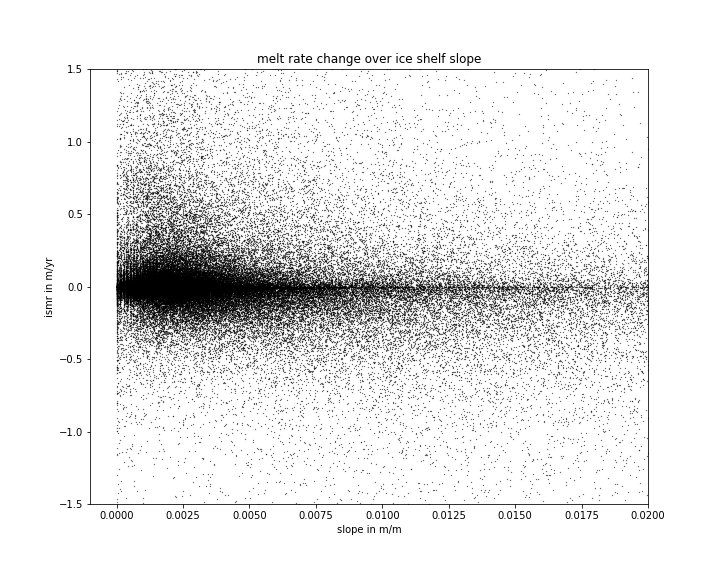

In [246]:
scatter(grd.gradZice,'slope in m/m','melt rate change over ice shelf slope',xlim=(-0.001,0.02),ylim=(-1.5,1.5))

In [131]:
depths = grd.zice*-1
mask = (grd.zice<0) & (grd.mask_rho==1)
dA = (1/(grd.pm*grd.pn)).where(mask)
rhoi = 916
ismr2bmb = dA*rhoi*(10**-12)
s2a = 365.25 * 24 * 3600

In [66]:
def make_bins(bin_quant,low,high,steps,mask=(grd.mask_rho==1) & (grd.zice < 0.0)):
    
    bins = np.linspace(low,high,steps)
    sep=(high-low)/steps
    
    dm = (tides.m-no_tides.m).where(mask)
    dA = ((grd.pm*grd.pn)**-1).where(mask)

    Ab = []
    dmb = []
    dbmbb = []

    s2a = 3600*24*365.25
    rhoi = 916
    ismr2bmb = dA*rhoi*(10**-12)

    for b in log_progress(bins):

        mask = (bin_quant > b) & (bin_quant <= b+sep)
        weights = dA.where(mask)/dA.where(mask).sum()

        Ab.append(dA.where(mask).sum().values*10**-9)
        dmb.append((dm*weights).sum().values)
        dbmbb.append((dm.where(mask)*ismr2bmb*s2a).sum().values) 
    
    return dmb,dbmbb,Ab

In [67]:
def bar_bin(dmb,dbmbb,Ab,bins,title,xlab,save=False):
    plt.close()
    fig,axes = plt.subplots(3,figsize=(8,8))
    ax1,ax2,ax3 = axes.flatten()
    bw = (bins[1]-bins[0])/3
    ax1.bar(bins,dmb,bw,color='k')
    ax2.bar(bins,dbmbb,bw,color='k')
    ax3.bar(bins,Ab,bw,color='k')
    ax1.set_ylabel('Delta ismr in m/yr')
    ax2.set_ylabel('Delta bmb in Gt/yr')
    ax3.set_ylabel('A in 10**3 km^2')
    for ax in axes.flatten(): 
        ax.grid(zorder=0)
    for ax in [ax1,ax2]:
        ax.set_xlabel('')
    ax3.set_xlabel(xlab)
    ax1.set_title(title)
    if save:
        plt.savefig(os.path.join(fig_dir,'bar_'+title.replace(' ','_')+'.png'),bbox_inches = "tight")
    plt.show()

<IPython.core.display.Javascript object>


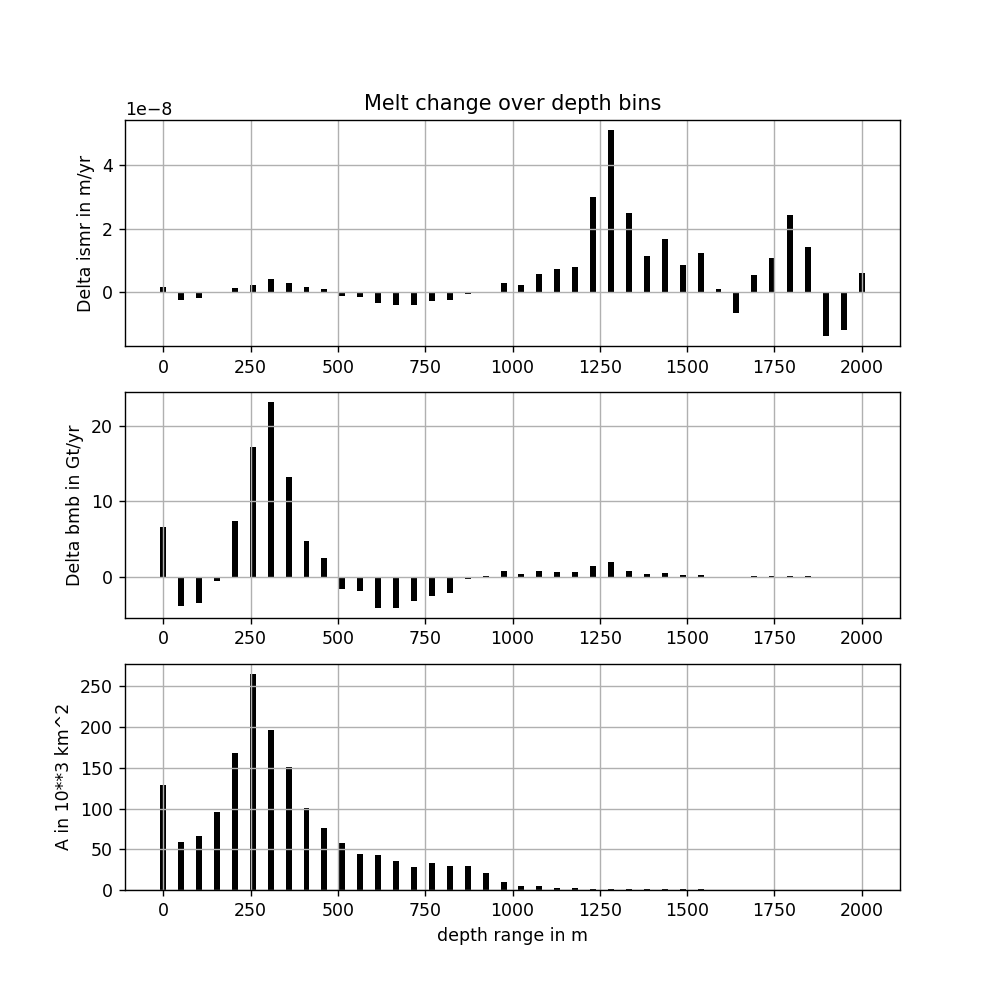

In [161]:
dm_db,dbmb_db,A_db = make_bins(-grd.zice,0,2000,40)
bar_bin(dm_db,dbmb_db,A_db,np.linspace(0,2000,40),'Melt change over depth bins','depth range in m',save=True)

<IPython.core.display.Javascript object>


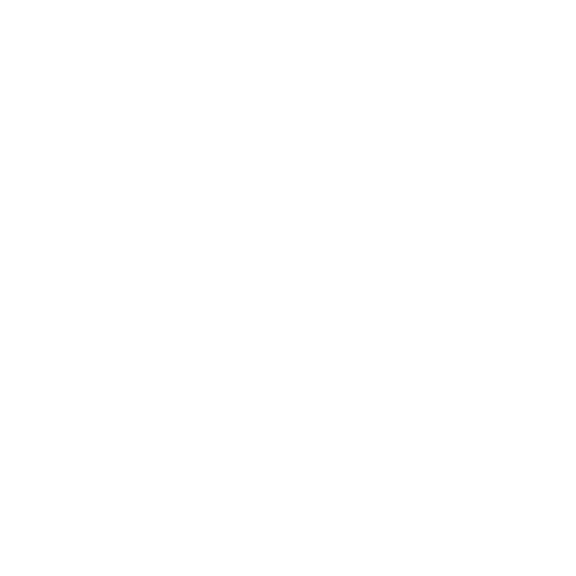

In [366]:
dm_sb,dbmb_sb,A_sb = make_bins(grd.gradZice,0,0.10,40)
bar_bin(dm_sb,dbmb_sb,A_sb,np.linspace(0,0.10,40),'Melt change over slope bins','slope range in m/m',save=True)

## normalized depth

In [94]:
for k,v in log_progress(shelves.items(),every=2):
    mask = v['mask']
    zmin,zmax = (grd.zice.where(mask).min(),grd.zice.where(mask).max())
    shelves[k]['nzice'] = (grd.zice.where(mask) - zmax)/(zmin-zmax)

In [117]:
nzice = np.zeros_like(grd.mask_rho)
nzice[:,:] = np.nan
for k,v in shelves.items():
    ii = v['nzice'].isnull()
    nzice[~ii]=v['nzice'].values[~ii]
grd['nzice'] = xr.DataArray(nzice,dims=('eta_rho','xi_rho'))

<IPython.core.display.Javascript object>


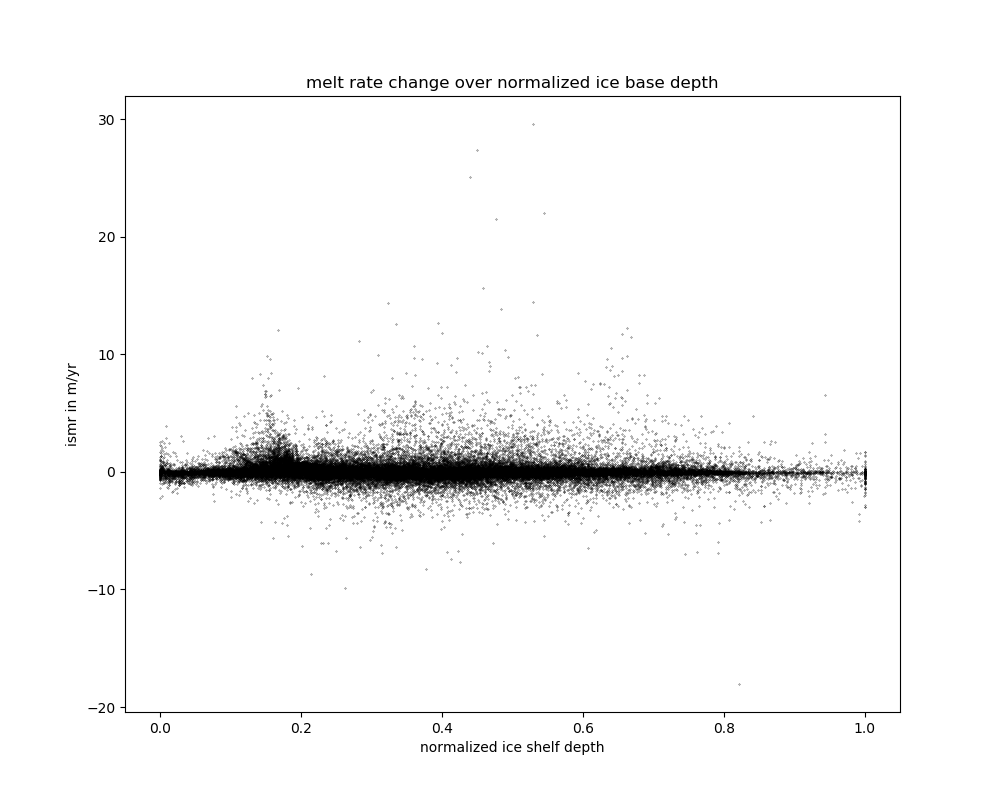

In [130]:
scatter(grd.nzice,'normalized ice shelf depth','melt rate change over normalized ice base depth',
        mask=~grd.nzice.isnull())

<IPython.core.display.Javascript object>


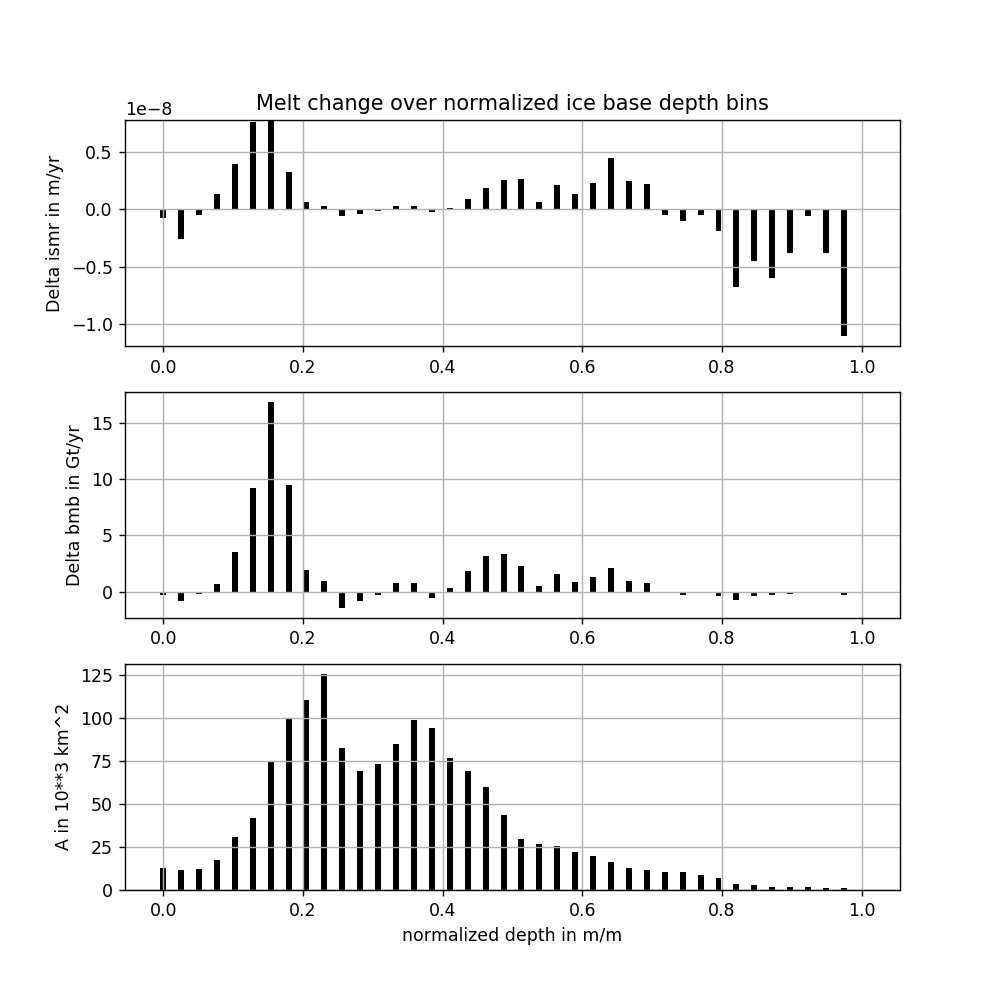

In [167]:
dmb,dbmbb,Ab = make_bins(grd.nzice,0,1,40,mask=~grd.nzice.isnull())
bar_bin(dmb,dbmbb,Ab,np.linspace(0,1,40),'Melt change over normalized ice base depth bins','normalized depth in m/m',save=True)

## Mean velocity change (tidal residual, ice pump, etc)

In [164]:
def make_rho_velo(ubar,vbar,grd):
    ubar_rho,vbar_rho = rotate_vector_roms(ubar.values,vbar.values,np.zeros_like(grd.mask_rho))
    velo_mag = np.sqrt(ubar_rho**2 + vbar_rho**2)
    
    return xr.DataArray(velo_mag,dims=grd.mask_rho.dims,name='velocity magnitude')

In [165]:
tides_velo = make_rho_velo(tides.ubar.squeeze(),tides.vbar.squeeze(),grd)
no_tides_velo = make_rho_velo(no_tides.ubar.squeeze(),no_tides.vbar.squeeze(),grd)

<IPython.core.display.Javascript object>


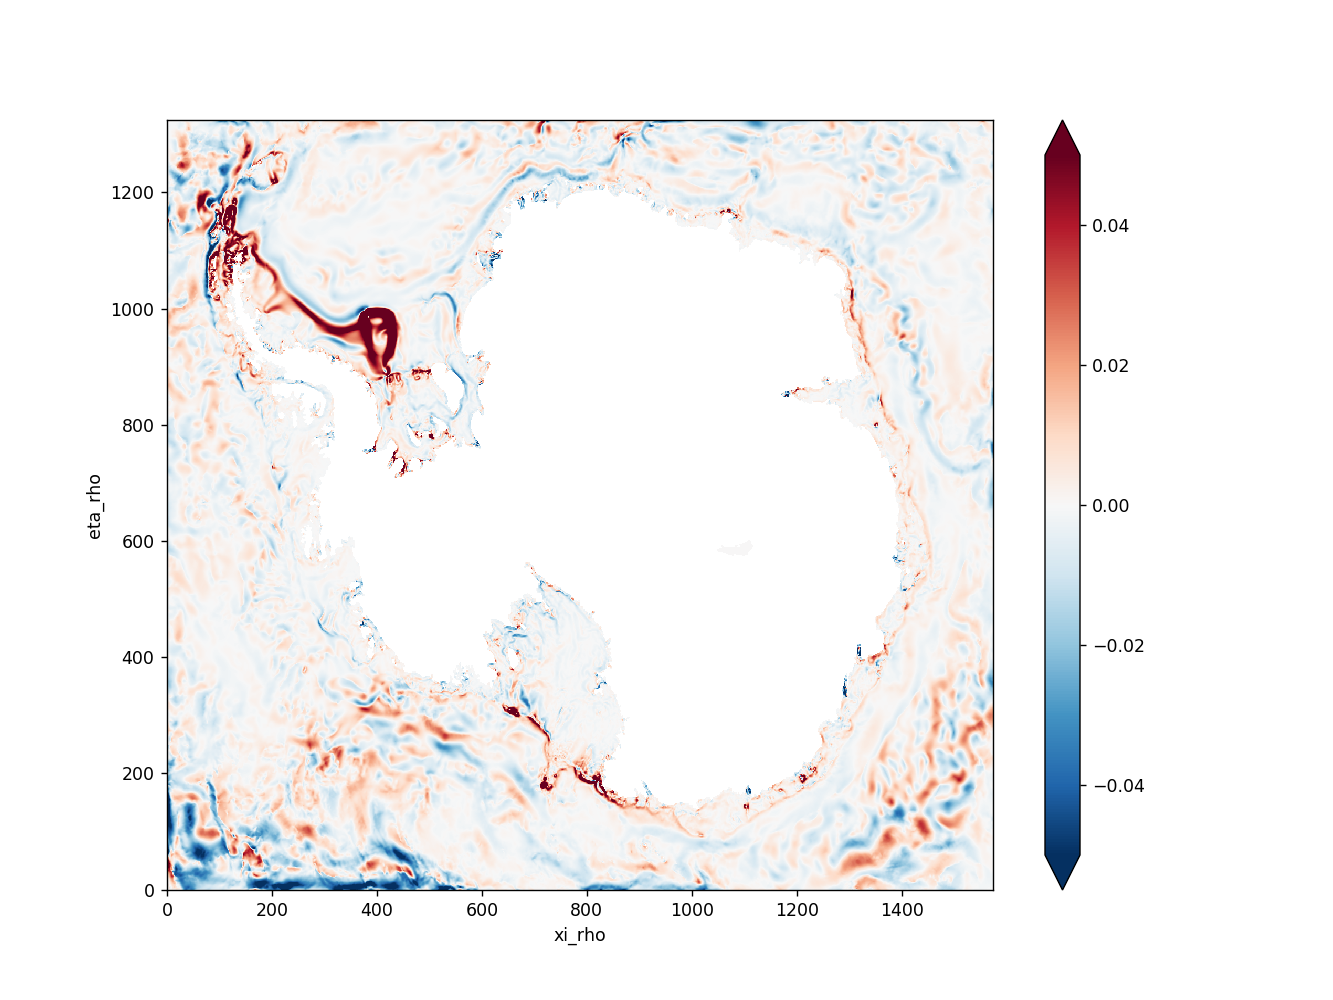

In [166]:
mask_is = (grd.mask_rho==1)
plt.close()
(tides_velo-no_tides_velo).where(mask_is).plot(size=8,vmax=0.05)

<IPython.core.display.Javascript object>


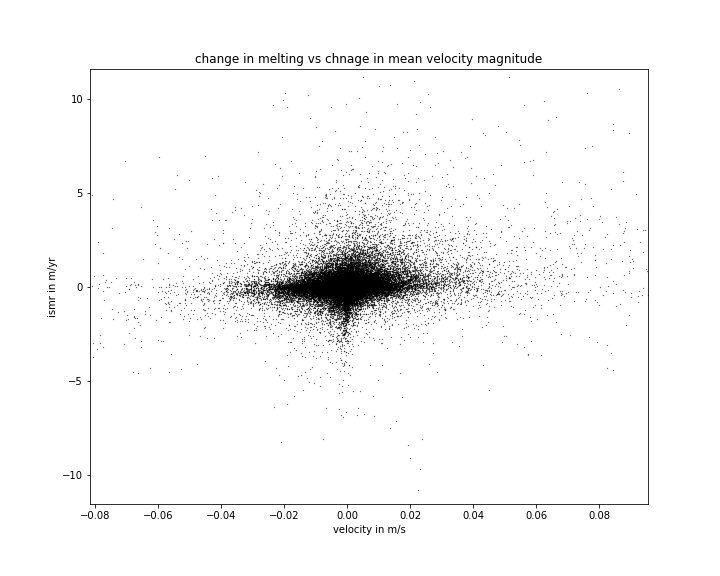

In [348]:
scatter(tides_velo-no_tides_velo,'velocity in m/s','change in melting vs chnage in mean velocity magnitude')

<IPython.core.display.Javascript object>


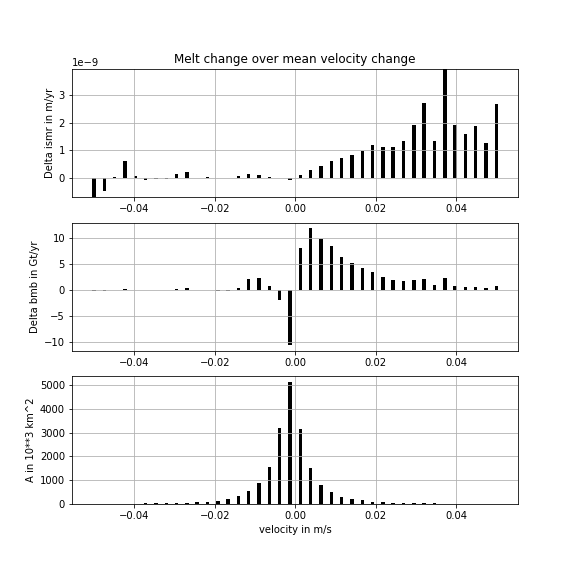

In [367]:
dm_vb,dbmb_vb,A_vb = make_bins(tides_velo-no_tides_velo,-0.05,0.05,40)
bar_bin(dm_vb,dbmb_vb,A_vb,np.linspace(-0.05,0.05,40),'Melt change over mean velocity change','velocity in m/s',save=True)

## Tidal oscillating current

In [25]:
file_path = os.path.join(data_dir,'raw','waom4','ocean_his_hr_0010.nc')
tides_hr = xr.open_dataset(file_path)

file_path = os.path.join(data_dir,'raw','waom4_nt','ocean_his_hr_0010.nc')
no_tides_hr = xr.open_dataset(file_path)

In [34]:
from scipy import signal
from tools.uvp_masks import uvp_masks

def detrend(da,mask,grd_key):
    out = da.copy()
    for eta in log_progress(grd['eta_'+grd_key]):
        if mask[eta,:].any():
            for xi in grd['xi_'+grd_key]:
                if mask[eta,xi]:
                    out[:,eta,xi] = signal.detrend(da[:,eta,xi].values)
            
    return out.where(mask)

mask = (grd.mask_rho==1) & (grd.zice<0)
mask_u,mask_v,_ = uvp_masks(mask)

for da in [tides_hr,no_tides_hr]:
    for velo,mask,grd_key in zip(['ubar','vbar'],[mask_u,mask_v],['u','v']):
        da[velo+'_detrend'] = detrend(da[velo],mask,grd_key)

tides_hr[['ubar_detrend','vbar_detrend']].to_netcdf(os.path.join(int_dir,'4TidesUvDetrend.nc'))
no_tides_hr[['ubar_detrend','vbar_detrend']].to_netcdf(os.path.join(int_dir,'4NoTidesUvDetrend.nc'))

In [ ]:
angle = np.zeros_like(grd.mask_rho)
def u_rms(ds):
    print('creating dummy u_rho array ...')
    u = ds['zeta'].copy()
    print('creating dummy v_rho array ...')
    v = ds['zeta'].copy()
    print('interpolating u and v onto rho grid ...')
    for time in log_progress(np.arange(ds.ocean_time.size)):
        u[time,:,:],v[time,:,:] = rotate_vector_roms(ds['ubar_detrend'][time].values,
                                                     ds['vbar_detrend'][time].values,
                                                     angle)
    print('calculating rms velocity magnitude')    
    rms_velo = xr.ufuncs.sqrt(xr.ufuncs.square(u)+xr.ufuncs.square(v)).mean('ocean_time')
    
    return rms_velo

In [ ]:
tides_hr['rms_velo'] = u_rms(tides_hr)
no_tides_hr['rms_velo'] = u_rms(no_tides_hr)
tidal_velo = tides_hr['rms_velo'] - no_tides_hr['rms_velo']
tidal_velo.to_netcdf(os.path.join(int_dir,'tidal_velo4.nc'))

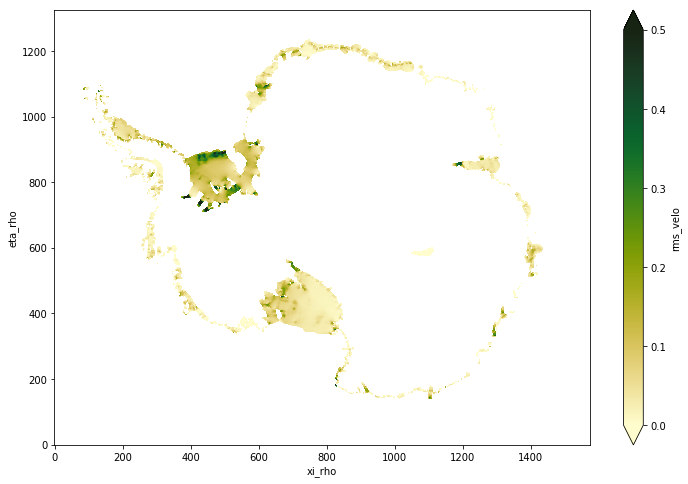

In [63]:
plt.close()
(tides_hr.rms_velo-no_tides_hr.rms_velo).plot(size=8,cmap=ocm.speed,vmin=0,vmax=0.5)

<IPython.core.display.Javascript object>


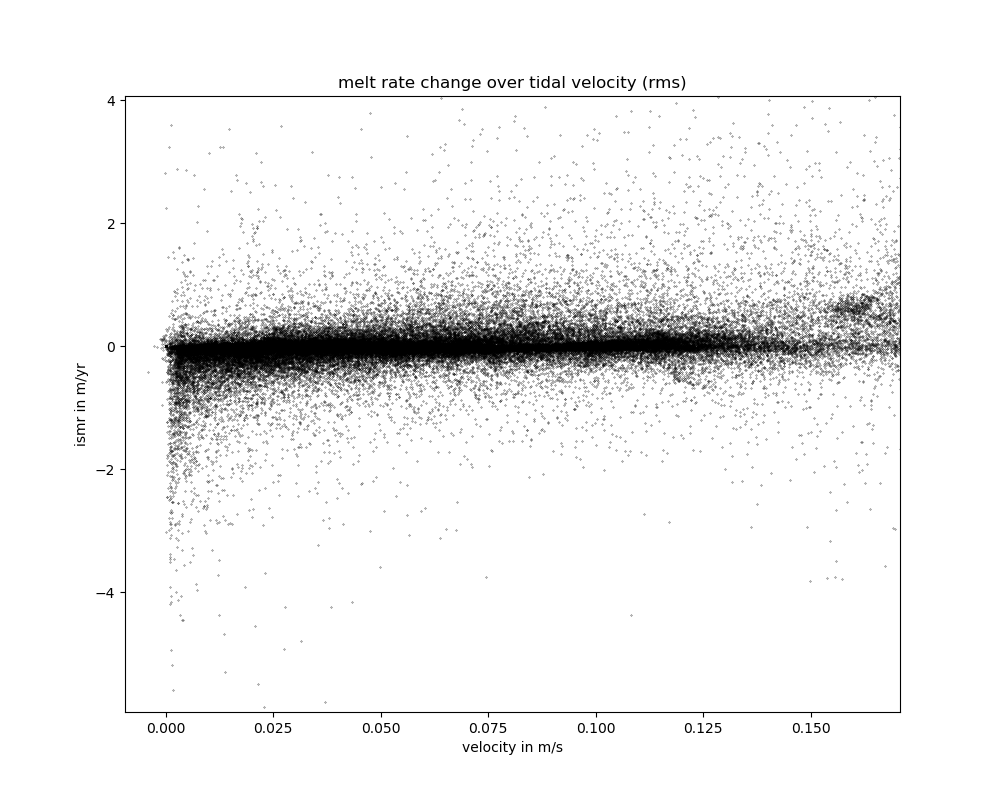

In [70]:
%matplotlib notebook
scatter(tidal_velo,'velocity in m/s','melt rate change over tidal velocity (rms)')

<IPython.core.display.Javascript object>


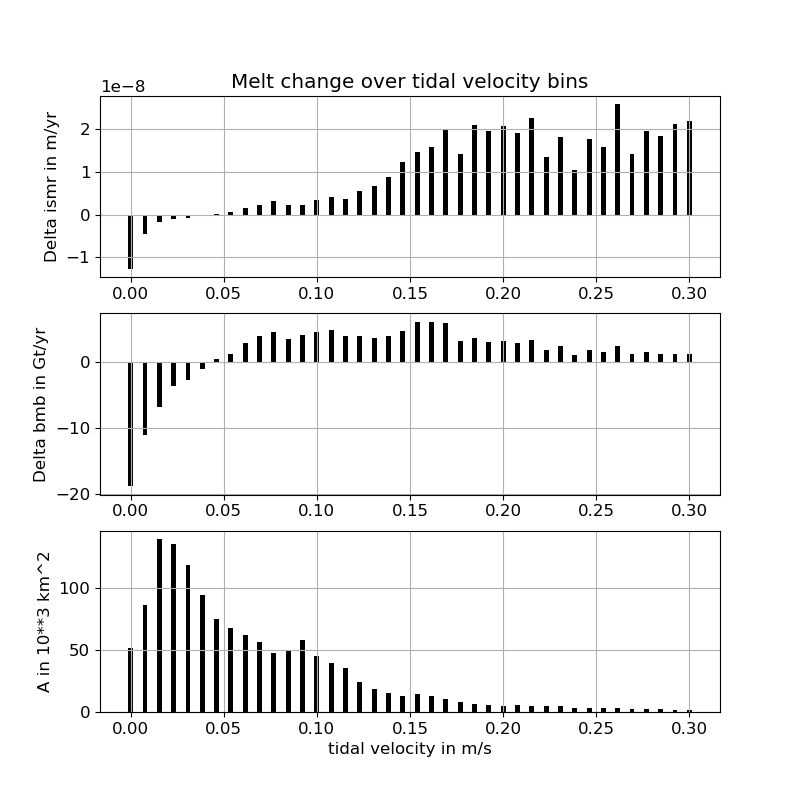

In [77]:
dmb,dbmbb,Ab = make_bins(tidal_velo,0,0.3,40)
bar_bin(dmb,dbmbb,Ab,np.linspace(0,0.3,40),'Melt change over tidal velocity bins','tidal velocity in m/s',save=True)

In [23]:
from visualization.scatter_shelves_avg import scatter_shelves_avg
%aimport visualization.scatter_shelves_avg
sector = np.load(os.path.join(int_dir,'mask_sector_4.npy')).item()
big_shelves = {k:v for k,v in shelves.items() if ( v['A'] > 5.0) & (k !='Total Antarctica')}

In [96]:
scatter_shelves_avg?

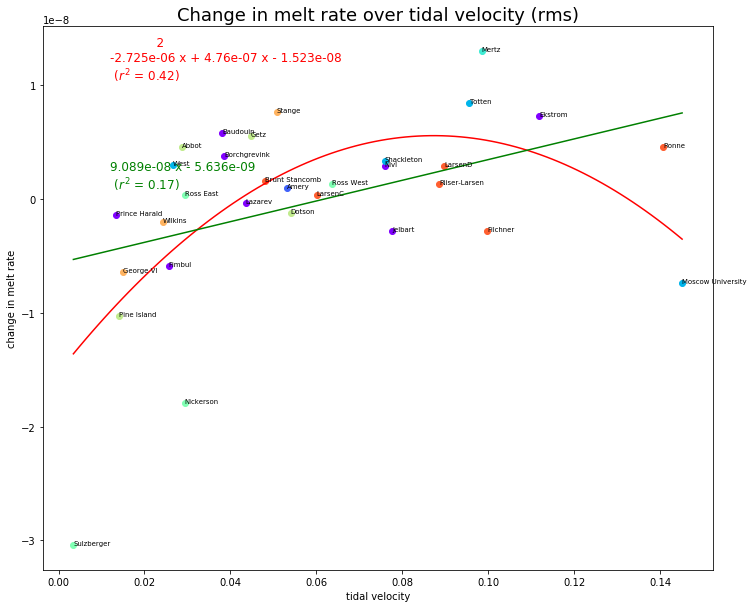

(array([0.02878416, 0.05305728, 0.03814012, 0.03861687, 0.04803526,
        0.05405057, 0.11187588, 0.09966874, 0.02564104, 0.01503948,
        0.04480199, 0.0775895 , 0.06010629, 0.08968367, 0.04351958,
        0.09843741, 0.1450879 , 0.02935384, 0.07585482, 0.01417612,
        0.01339241, 0.088557  , 0.14065005, 0.02949238, 0.06371441,
        0.07592703, 0.05082871, 0.0034604 , 0.09554424, 0.02666076,
        0.02421531]),
 array([ 4.59274530e-09,  9.23717880e-10,  5.75144954e-09,  3.72497699e-09,
         1.55421753e-09, -1.22398813e-09,  7.28757366e-09, -2.80976065e-09,
        -5.91882943e-09, -6.39597930e-09,  5.51022339e-09, -2.85426838e-09,
         3.74888065e-10,  2.90278068e-09, -4.05452505e-10,  1.30017161e-08,
        -7.43034212e-09, -1.79783708e-08,  2.87302448e-09, -1.03250315e-08,
        -1.39400469e-09,  1.29656619e-09,  4.59509852e-09,  3.71700670e-10,
         1.31782796e-09,  3.28767435e-09,  7.65059927e-09, -3.04199830e-08,
         8.46596482e-09,  2.93404434e-

In [99]:
%matplotlib inline
scatter_shelves_avg(tidal_velo,tides.m-no_tides.m,'Change in melt rate over tidal velocity (rms)','tidal velocity','change in melt rate',big_shelves,sector,save=True)

# ustar Tstar relation changes

In [5]:
from tools.calc_melt_frc import calc_ustar,calc_frc,calc_insituTemp
tidal_velo = xr.open_dataarray(os.path.join(int_dir,'tidal_velo4.nc'))

mask = ((grd.zice<0) & (grd.mask_rho==1))
m = tides.m.where(mask).squeeze()
Sm = tides.salt.isel(s_rho=30).where(mask).squeeze()
Tpot = tides.temp.isel(s_rho=30).where(mask).squeeze()
zice = grd.zice.where(mask)

#Tm = calc_insituTemp(mask,Tpot,Sm,zice)
#Tm.to_netcdf(os.path.join(int_dir,'situTemp.nc'))
Tm = xr.open_dataarray(os.path.join(int_dir,'situTemp4.nc')).where(mask)

u = tides.u
v = tides.v
ustar = calc_ustar(u,v,mask) + (tidal_velo*np.sqrt(5.0e-3))
Tfr,Sfr,Tdr = calc_frc(Tm,Sm,zice,ustar,grd.f.where(mask),m,mask)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [6]:
m_nt = no_tides.m.where(mask).squeeze()
Sm_nt = no_tides.salt.isel(s_rho=30).where(mask).squeeze()
Tpot_nt = no_tides.temp.isel(s_rho=30).where(mask).squeeze()

#Tm_nt = calc_insituTemp(mask,Tpot_nt,Sm_nt,zice)
#Tm_nt.to_netcdf(os.path.join(int_dir,'situTemp4nt.nc'))
Tm_nt = xr.open_dataarray(os.path.join(int_dir,'situTemp4_nt.nc')).where(mask)

u_nt = no_tides.u
v_nt = no_tides.v
ustar_nt = calc_ustar(u_nt,v_nt,mask)
Tfr_nt,Sfr_nt,Tdr_nt = calc_frc(Tm_nt,Sm_nt,zice,ustar_nt,grd.f.where(mask),m_nt,mask)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [11]:
from visualization.scatter_shelves_avg import find_sector, make_shelves_avg,polyfit
shelves = np.load(os.path.join(int_dir,'shelves4.npy')).item()

shelves = {k:v for k,v in shelves.items() if ustar.where(v['mask']).sum()!=0.0} 

for da,name in zip([m,Tdr,ustar,Tfr,Sfr,Tdr*ustar,Tfr*ustar],
                   ['ismr','Tdr','ustar','Tfr','Sfr','Tdr*ustar','Tfr*ustar']):
    print('processing '+name)
    shelves = make_shelves_avg(da,shelves,name)
    
shelves = {k:v for k,v in shelves.items() if np.isnan(v['ustar'])==False}

processing ismr


processing Tdr


processing ustar


processing Tfr


processing Sfr


processing Tdr*ustar


processing Tfr*ustar


In [12]:
for da,name in zip([m_nt,Tdr_nt,ustar_nt,Tfr_nt,Sfr_nt,Tdr_nt*ustar_nt,Tfr*ustar_nt],
                   ['ismr_nt','Tdr_nt','ustar_nt','Tfr_nt','Sfr_nt','Tdr*ustar_nt','Tfr*ustar_nt']):
    print('processing '+name)
    shelves = make_shelves_avg(da,shelves,name)

processing ismr_nt


processing Tdr_nt


processing ustar_nt


processing Tfr_nt


processing Sfr_nt


processing Tdr*ustar_nt


processing Tfr*ustar_nt


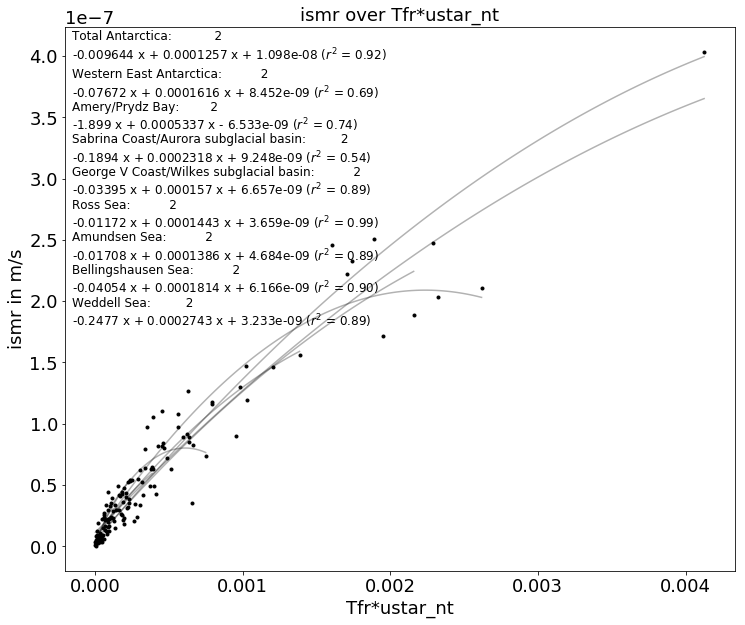

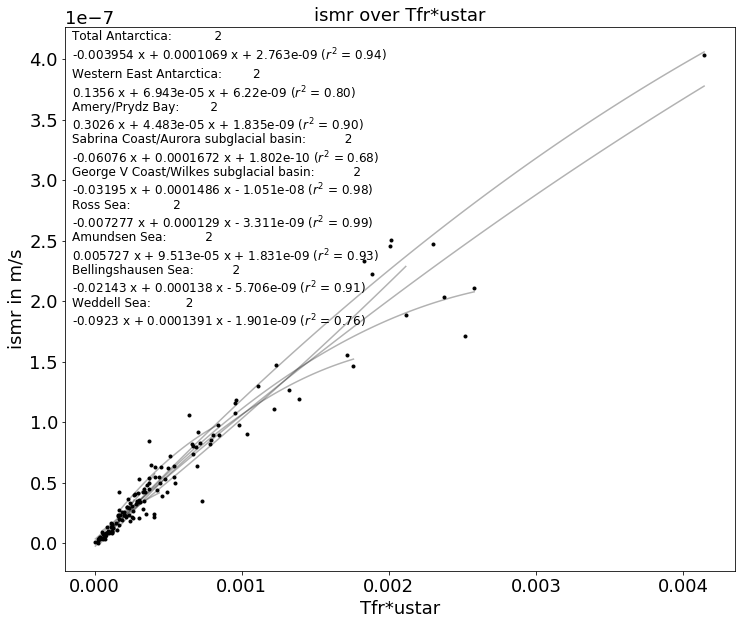

In [34]:
for x_name in ['Tfr*ustar_nt','Tfr*ustar']:
    scatter_shelves_avg(x_name,'ismr','ismr over '+x_name,x_name,'ismr in m/s',sector_dict=sector)

In [13]:
import matplotlib
def scatter_tides(x_quant,y_quant,title,xlab,ylab,shelves_dict=shelves,save=False,big=False):
    
    matplotlib.rcParams.update({'font.size': 18})
    
    plt.close()
    fig,ax = plt.subplots(figsize=(12,10))
    
    x_ar={}
    y_ar={}
    
    for t,c,pos in zip(['_nt',''],['r','g'],[0.9,0.8]):
        
        x_all=[]
        y_all=[]

        for key,data in shelves_dict.items():
            
            if big:
                if data['A']<5: continue

        
            if t == '_nt':
                x_ar[key]=[]
                y_ar[key]=[]
        
            x=shelves_dict[key][x_quant+t]
            y=shelves_dict[key][y_quant+t]
                   
            ax.plot(x,y,'.',label=key,c=c)
            #if res == '2':
            #    ax.annotate(key,(x,y),size='x-small')

            x_ar[key].append(x)
            y_ar[key].append(y)
        
            x_all.append(x)
            y_all.append(y)
            
        x_all = np.array(x_all).squeeze()
        y_all = np.array(y_all).squeeze()
    
        xp,p,Rsquared = polyfit(x_all,y_all,2)        
        ax.plot(xp,p(xp),'-',label='constrained poly fit',alpha=0.3,c=c)
        if t=='':
            label='4km with tides:'
        else:
            label='4km without tides:'
            
        ax.text(0.01,pos,label+str(p)+' ($r^2$ = %.2f)' %(Rsquared),transform=ax.transAxes,
                fontsize=16,color=c)       

        #xp,p,Rsquared = polyfit(x_all,y_all,1)        
        #ax.plot(xp,p(xp),'-',label='constrained poly fit',alpha=0.3,c=c)
        #ax.text(0.1,pos-0.05,str(p)+'\n ($r^2$ = %.2f)' %(Rsquared),transform=ax.transAxes,
        #        fontsize=12,color=c,alpha=0.3)      
    
    for key in x_ar:
        ax.annotate("", xy=(x_ar[key][1],y_ar[key][1]), xytext=(x_ar[key][0],y_ar[key][0]),
                    arrowprops=dict(arrowstyle="->",color='k',alpha=0.3))
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title,fontsize=18)
    
    if save:
        plt.savefig(os.path.join(fig_dir,'scatter_shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=300,bbox_inches = "tight")    
    plt.show()

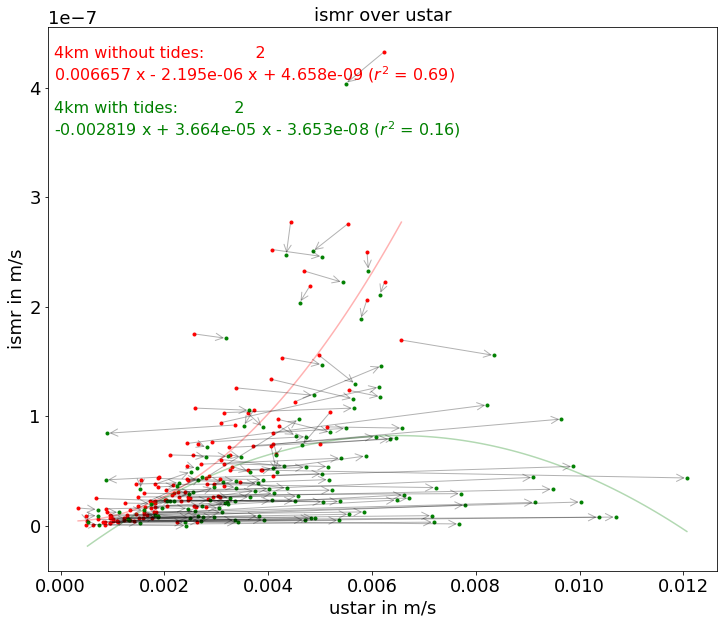

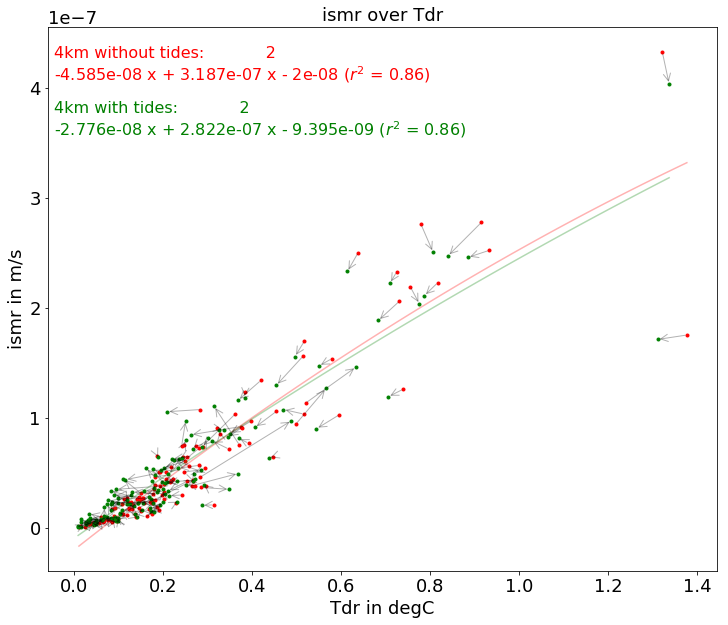

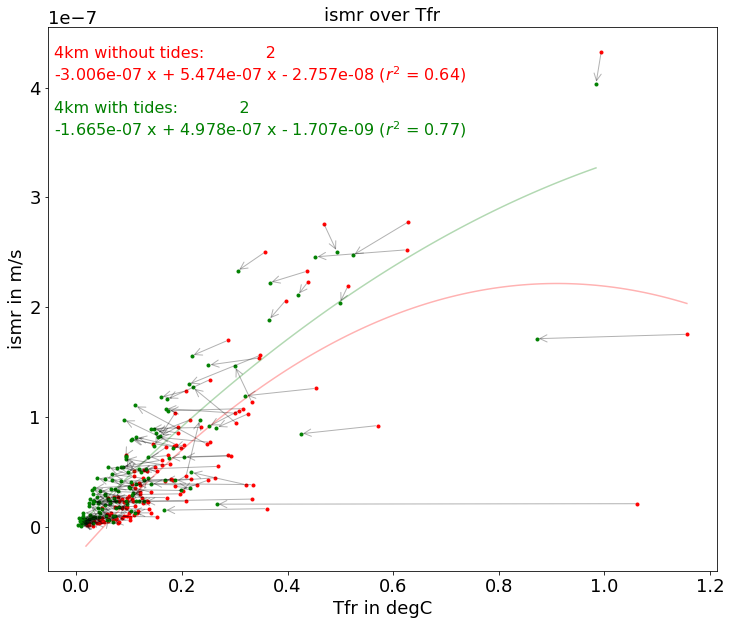

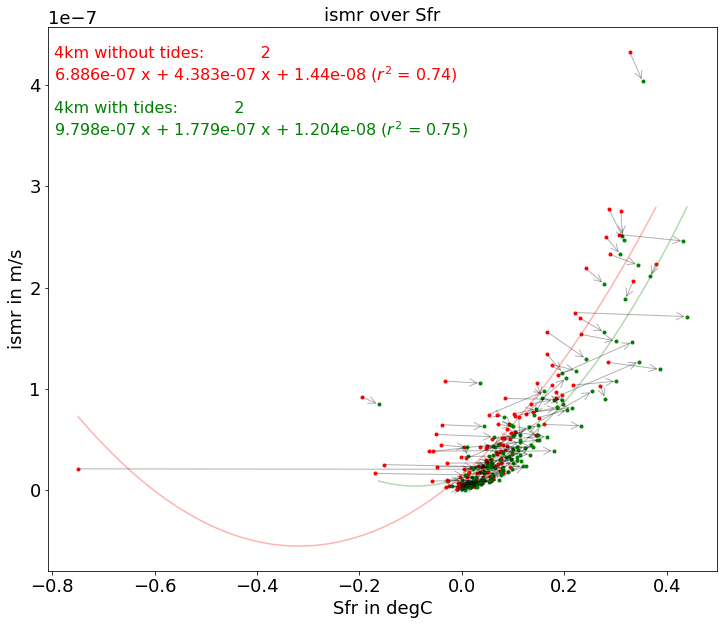

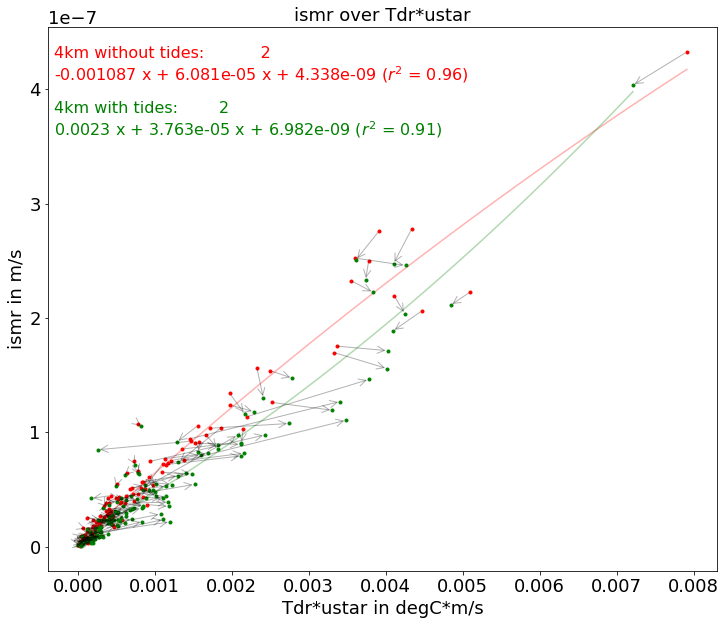

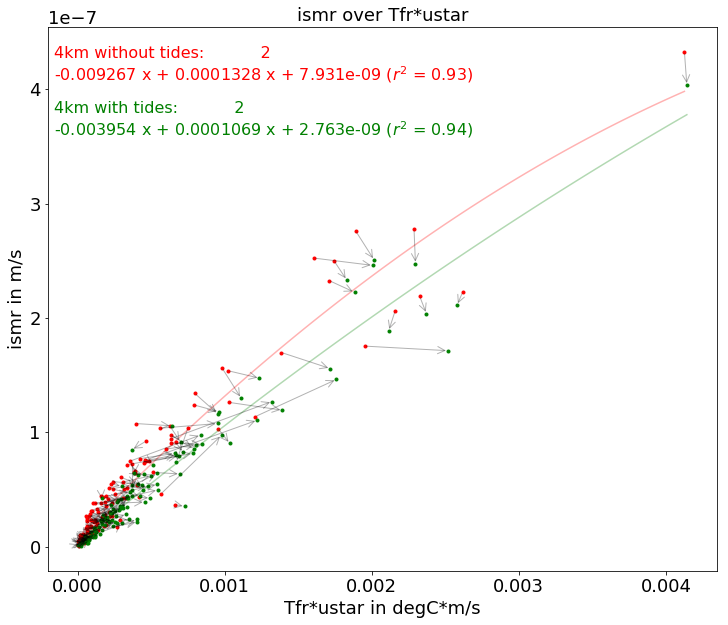

In [16]:
for x_name,xlab in zip(['ustar','Tdr','Tfr','Sfr','Tdr*ustar','Tfr*ustar'],
                       ['m/s','degC','degC','degC','degC*m/s','degC*m/s']):
    scatter_tides(x_name,'ismr','ismr over '+x_name,x_name+' in '+xlab,'ismr in m/s',save=True)

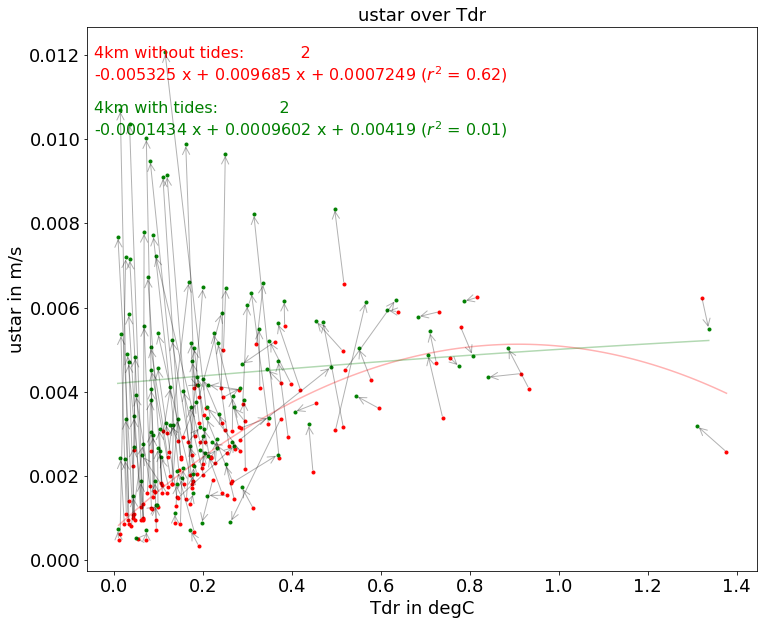

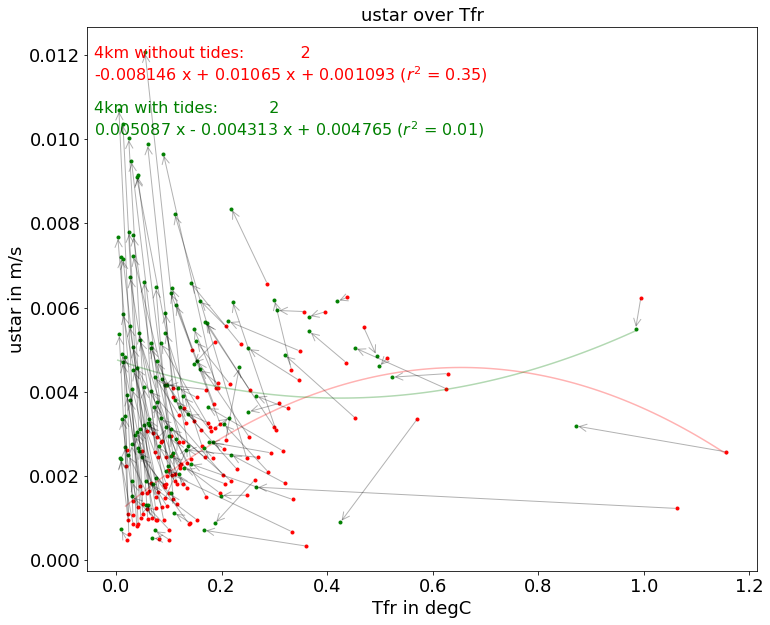

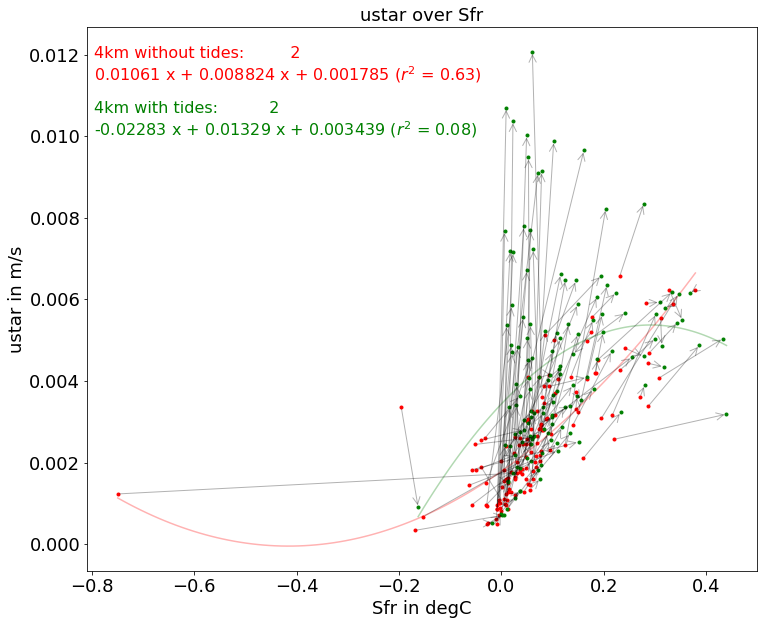

In [17]:
for x_name,xlab in zip(['Tdr','Tfr','Sfr'],
                       ['degC','degC','degC']):
    scatter_tides(x_name,'ustar','ustar over '+x_name,x_name+' in '+xlab,'ustar in m/s',save=True)

In [26]:
for k,v in log_progress(shelves.items(),name='ice shelf'):
    
    bmb,ismr,A = calc_mass_loss(tides.m,grd,v['mask'])
    
    shelves[k]['bmb'] = bmb
    shelves[k]['ismr'] = ismr
    shelves[k]['A'] = A
    
    bmb_nt,ismr_nt,A = calc_mass_loss(no_tides.m,grd,v['mask'])
    
    shelves[k]['bmb_nt'] = bmb_nt
    shelves[k]['ismr_nt'] = ismr_nt

In [28]:
sector = np.load(os.path.join(int_dir,'mask_sector_4.npy')).item()
shelves,sector=find_sector(shelves,sector)
np.save(shelves_path,shelves)

In [66]:
df_shelves = {}
for k,v in shelves.items():
    df_shelves[k] = {k:v for k,v in v.items() if k in ['bmb','A','ismr','lon_mid','bmb_nt','ismr_nt',
                                                      'ustar','Tdr','Tfr','Sfr','Tdr*ustar','Tfr*ustar',
                                                      'ustar_nt','Tdr_nt','Tfr_nt','Sfr_nt','Tdr*ustar_nt',
                                                       'Tfr*ustar_nt','sector','sector_color']}

import pandas as pd
df_shelves = pd.DataFrame.from_dict(df_shelves,orient='index').sort_values('lon_mid')

for key in ['bmb','A','ismr','lon_mid','bmb_nt','ismr_nt','ustar','Tdr','Tfr','Sfr','Tdr*ustar','Tfr*ustar',
            'ustar_nt','Tdr_nt','Tfr_nt','Sfr_nt','Tdr*ustar_nt','Tfr*ustar_nt']:
    df_shelves[key] = df_shelves[key].astype(float)

In [80]:
%matplotlib inline
def bar_shelves(quant,title,ylab,save=False):
    plt.close()
    fig,ax = plt.subplots(figsize=(24,6))
    quant.plot.bar(ax=ax,color=df_shelves.sector_color,fontsize=12)
    ax.grid()
    ax.set_ylabel(ylab)
    if save:
        plt.savefig(os.path.join(fig_dir,'bar_shelves_'+title.replace('/','_').replace(' ','_')+'.png'),
                    bbox_inches='tight')
    plt.show()

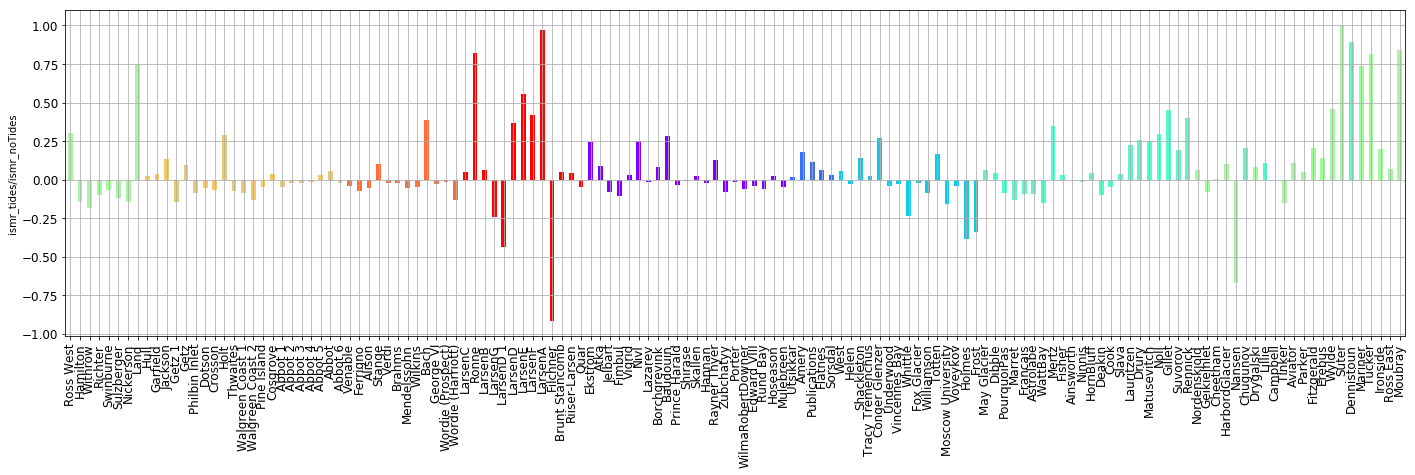

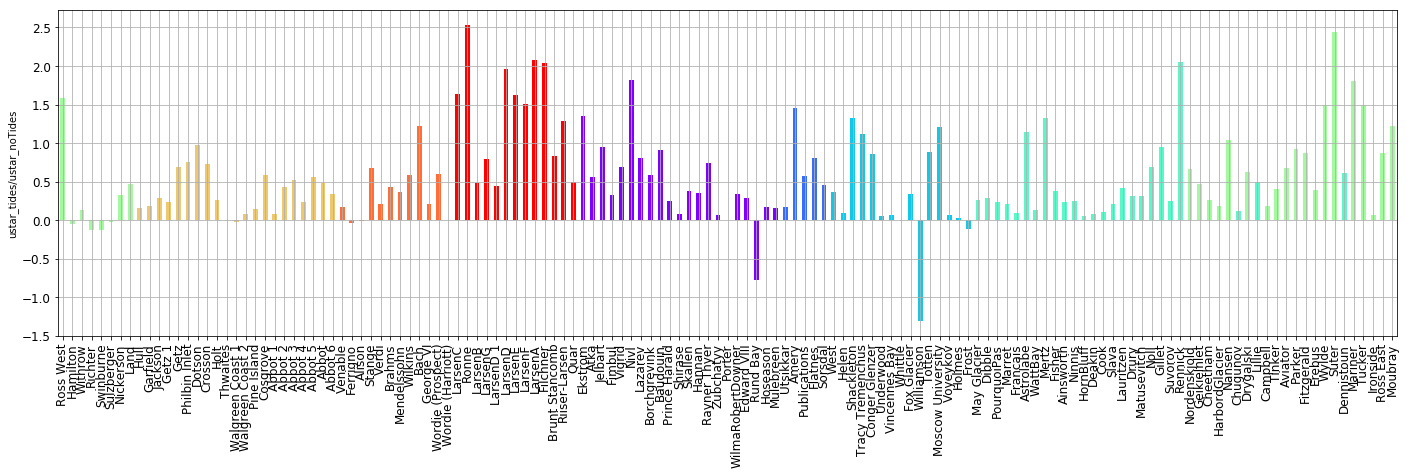

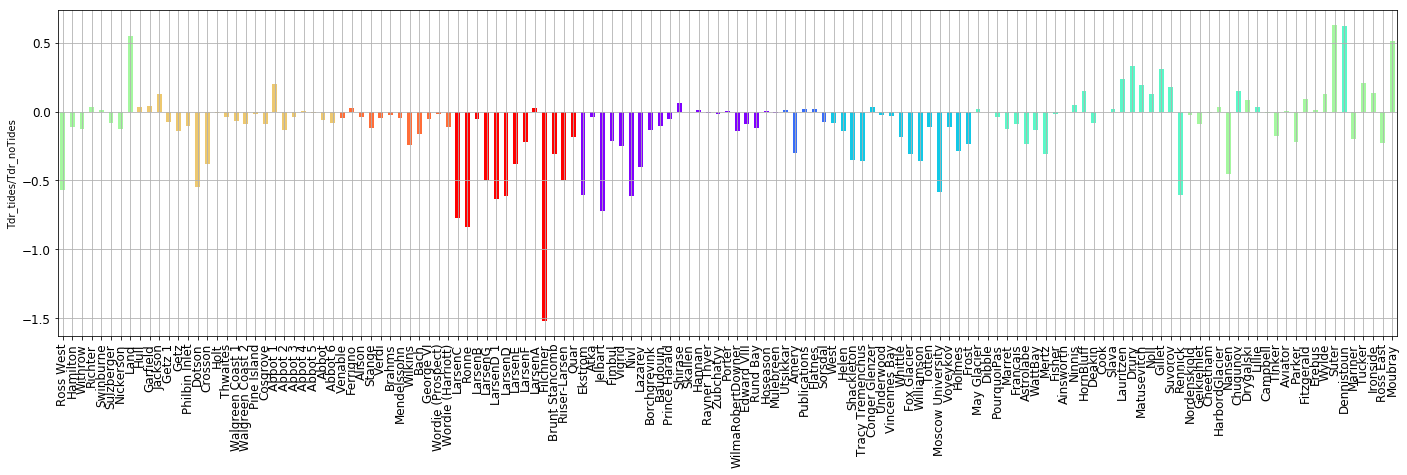

In [81]:
for key in ['ismr','ustar','Tdr']:
    bar_shelves(np.log(df_shelves[key]/df_shelves[key+'_nt']),key+' change',key+'_tides/'+key+'_noTides',save=True)

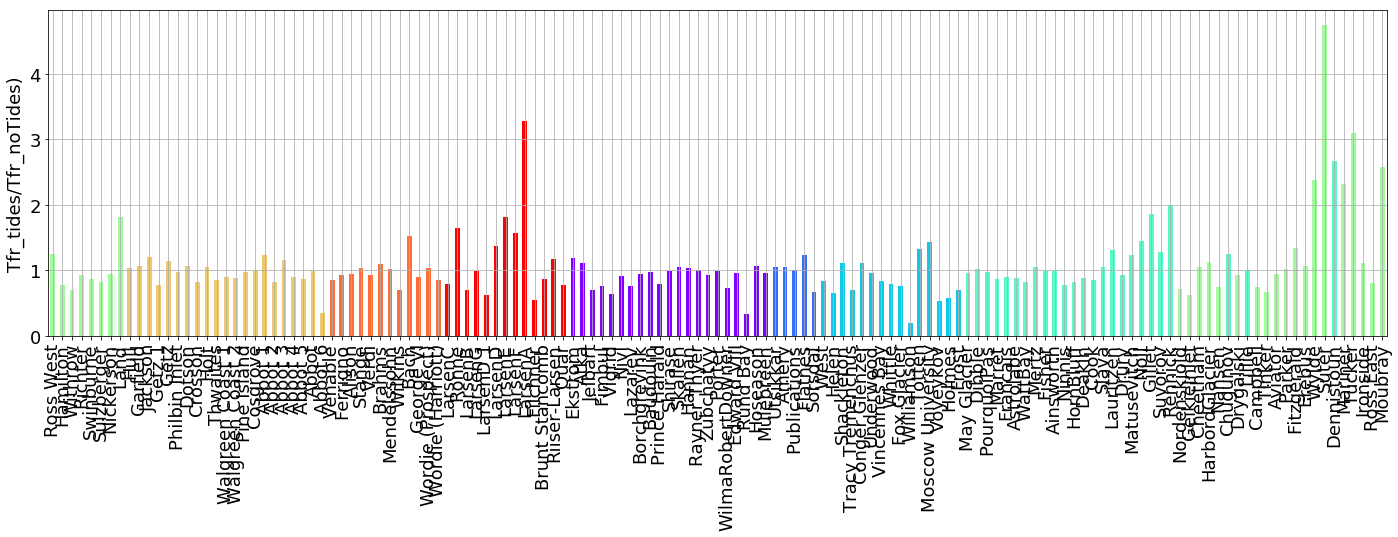

In [76]:
bar_shelves((df_shelves['Tfr*ustar']/df_shelves['Tfr*ustar_nt']),'Tfr*ustar change','Tfr_tides/Tfr_noTides)',save=True)

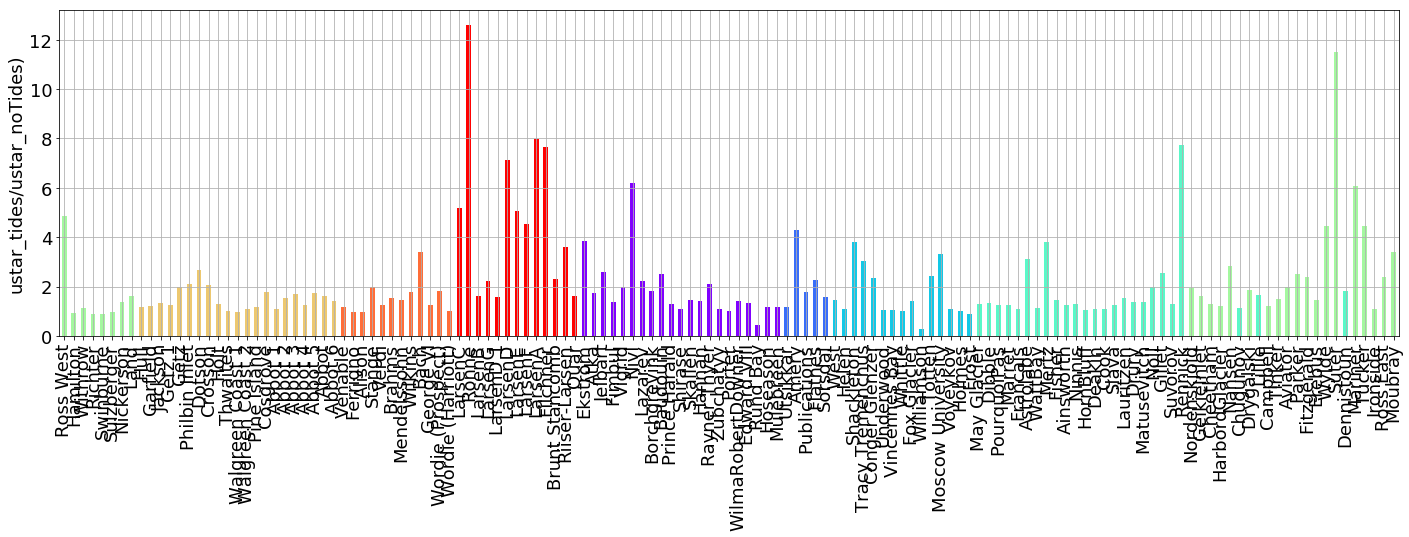

In [77]:
bar_shelves((df_shelves.ustar/df_shelves.ustar_nt),'ustar change','ustar_tides/ustar_noTides)',save=True)

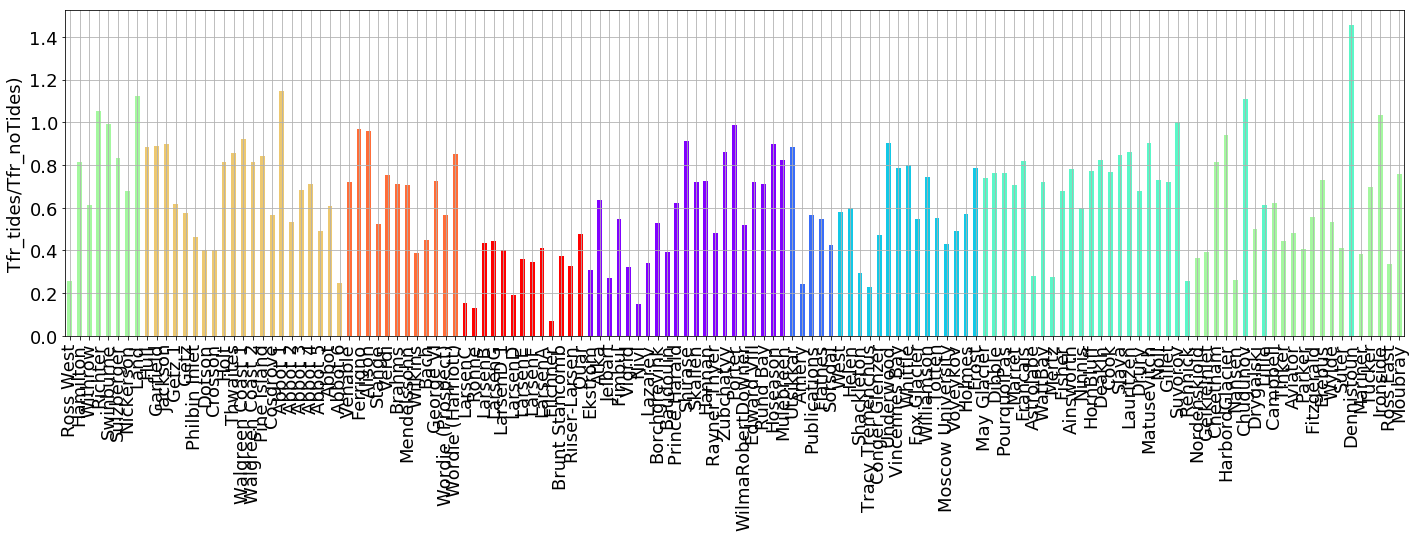

In [78]:
bar_shelves((df_shelves.Tfr/df_shelves.Tfr_nt),'Tfr change','Tfr_tides/Tfr_noTides)',save=True)

<IPython.core.display.Javascript object>


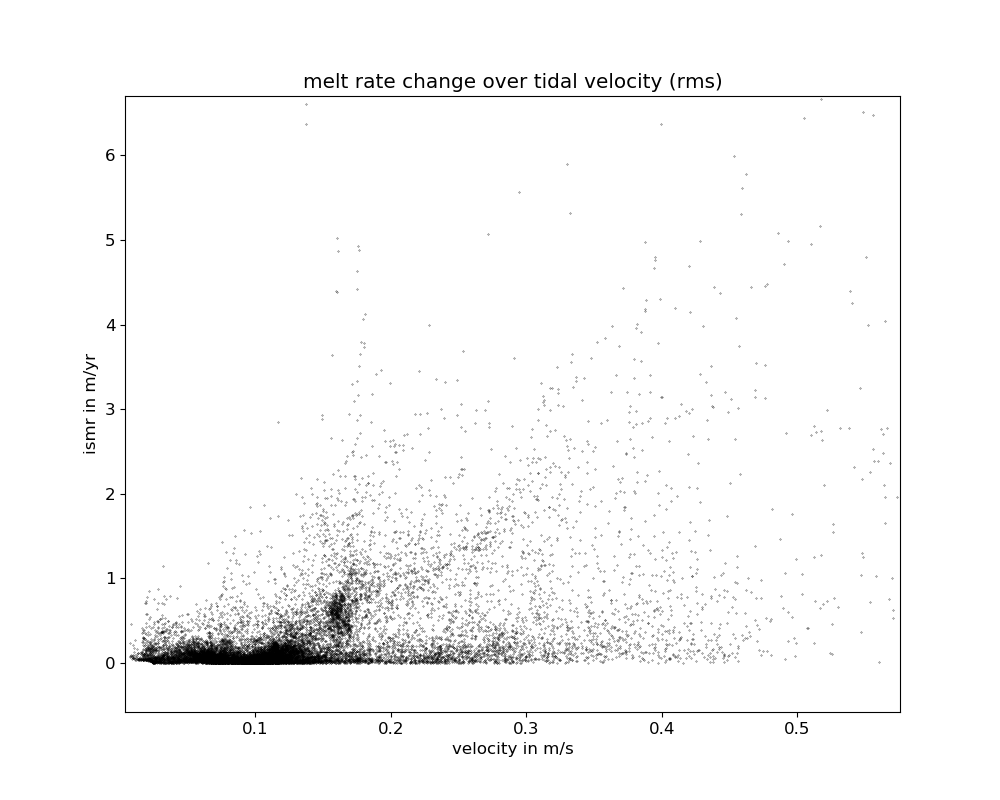

In [76]:
scatter_square(tidal_velo,'velocity in m/s','melt rate change over tidal velocity (rms)',mask=shelves['Ronne']['mask'])

In [ ]:
shelves,sector=find_sector(shelves,sector)

In [196]:
from tools.ustar import calc_ustar
from tools.melt_frc import calc_frc

Tm = xr.open_dataarray(os.path.join(data_dir,'analysis','interim','situTemp4.nc'))
Tm_nt = xr.open_dataarray(os.path.join(data_dir,'analysis','interim','situTemp4_nt.nc'))
Tm2 = xr.open_dataarray(os.path.join(data_dir,'analysis','interim','situTemp2.nc'))

In [49]:
mask = (grd.zice < 0.0)&(grd.mask_rho==1)

Sm_nt = no_tides.salt.isel(s_rho=30).where(mask) 
Sm = tides.salt.isel(s_rho=30).where(mask) 

ustar_nt = calc_ustar(no_tides.u,no_tides.v,mask)
ustar = calc_ustar(tides.u,tides.v,mask)

Tfr_nt,Sfr_nt,Tdr_nt = calc_frc(Tm_nt,Sm_nt,grd.zice,ustar_nt,grd.f,no_tides.m,mask)
Tfr,Sfr,Tdr = calc_frc(Tm,Sm,grd.zice,ustar,grd.f,tides.m,mask)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [219]:
mask2 = (grd2.zice < 0.0) & (grd2.mask_rho==1)
Sm2 = salt2.isel(s_rho=30).where(mask2).squeeze()
ustar2 = calc_ustar(u2.squeeze(),v2.squeeze(),mask2)
Tfr2,Sfr2,Tdr2 = calc_frc(Tm2.squeeze(),Sm2.squeeze(),grd2.zice,ustar2,grd2.f,m2.squeeze(),mask2)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [94]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22}) 

def plot_map(da,grd,title,cbar_label,cmap,vrange):
    plt.close()
    fig,ax = plt.subplots(figsize=(10,8))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=-2*std
        vmax=+2*std
    else:
        vmin,vmax=vrange
    da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label': cbar_label})
    ax.set_title(title)
    ax.set_ylim([250/2,2500/2])
    ax.set_xlim([200/2,2900/2])
    ax.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,'tmp','tidal_melting_'+title.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
    plt.show()

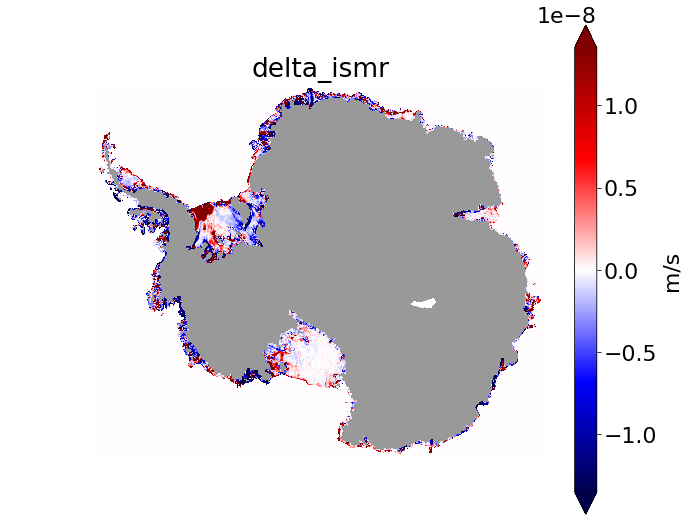

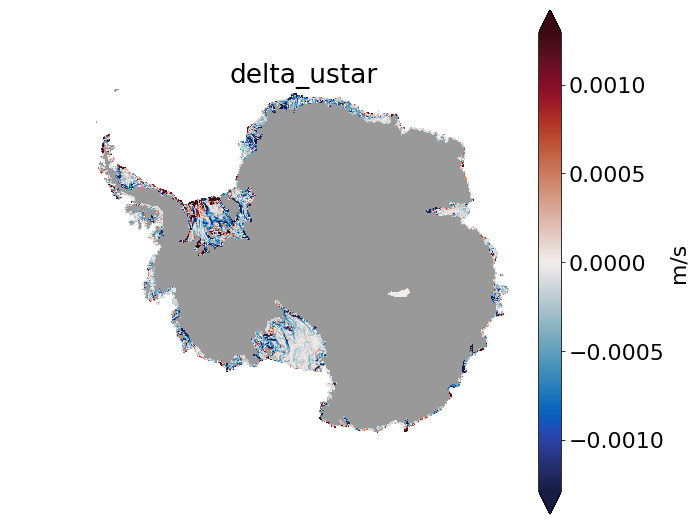

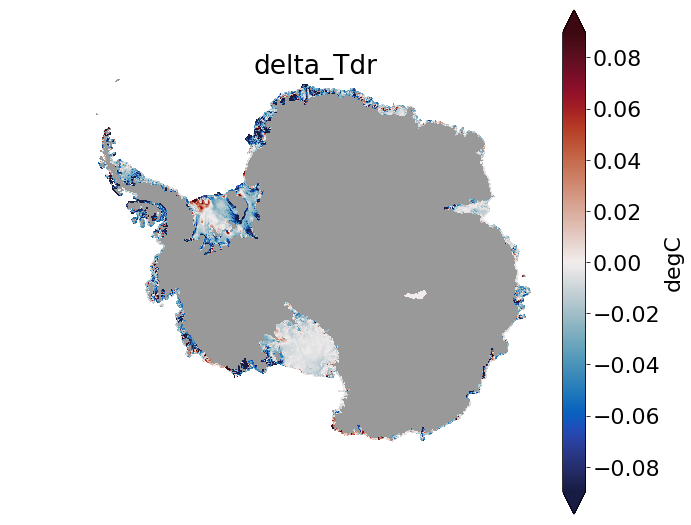

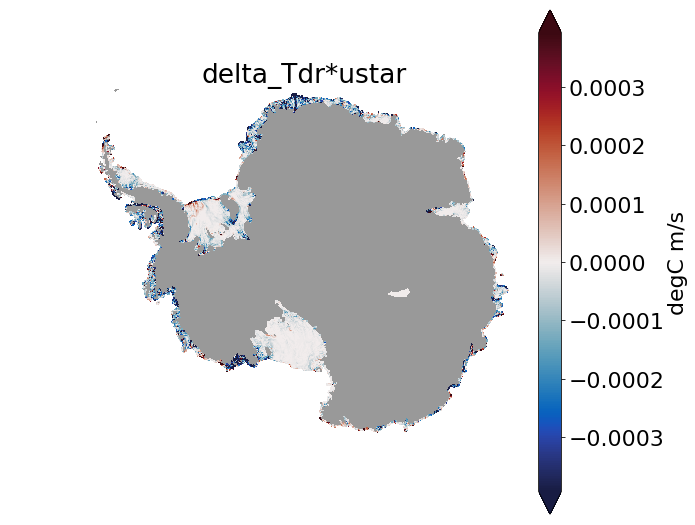

In [93]:
for da,title,cbt,cmap,vrange in zip([tides.m-no_tides.m,ustar-ustar_nt,Tdr-Tdr_nt,Tdr*ustar-Tdr_nt*ustar_nt],
                             ['delta_ismr','delta_ustar','delta_Tdr','delta_Tdr*ustar'],
                             ['m/s','m/s','degC','degC m/s'],
                             [plt.cm.seismic,ocm.balance,ocm.balance,ocm.balance],
                             [None,None,None,None]):
    plot_map(da,grd,title,cbt,cmap,vrange)

In [87]:
(Tdr_nt*ustar_nt).mean()*100

<xarray.DataArray ()>
array(0.034304)
Coordinates:
    s_rho       float64 -0.01613
    ocean_time  datetime64[ns] 2015-06-30T12:00:00

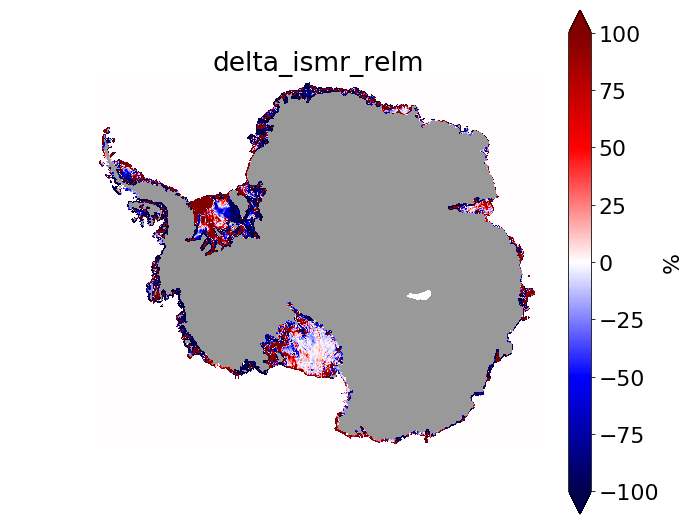

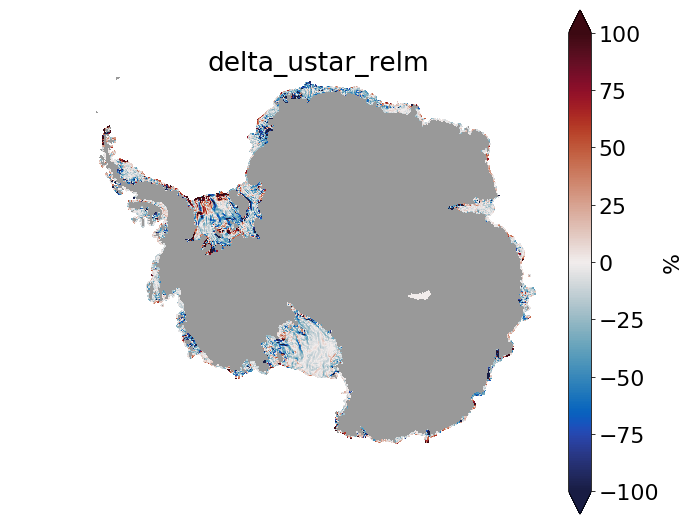

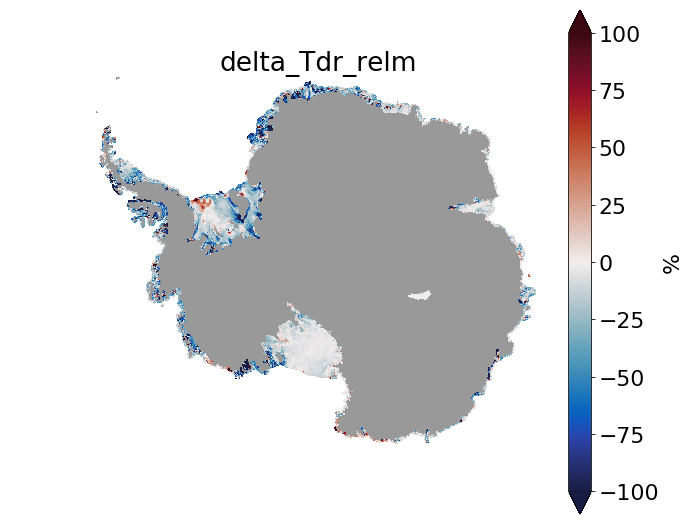

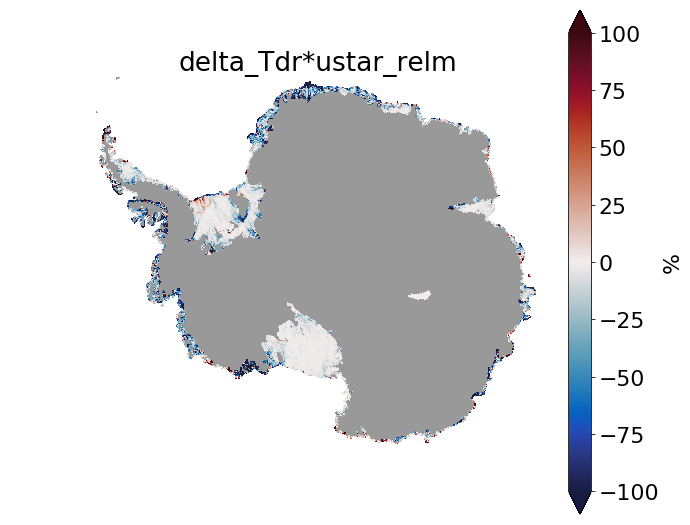

In [96]:
v_range=(-100,100)
for da,title,cbt,cmap,vrange in zip([(tides.m-no_tides.m)/no_tides.m.mean()*100,
                                     (ustar-ustar_nt)/ustar_nt.mean()*100,
                                     (Tdr-Tdr_nt)/Tdr_nt.mean()*100,
                                     (Tdr*ustar-Tdr_nt*ustar_nt)/(Tdr_nt*ustar_nt).mean()*100],
                             ['delta_ismr_relm','delta_ustar_relm','delta_Tdr_relm','delta_Tdr*ustar_relm'],
                             ['%','%','%','%'],
                             [plt.cm.seismic,ocm.balance,ocm.balance,ocm.balance],
                             [v_range,v_range,v_range,v_range]):
    plot_map(da,grd,title,cbt,cmap,vrange)

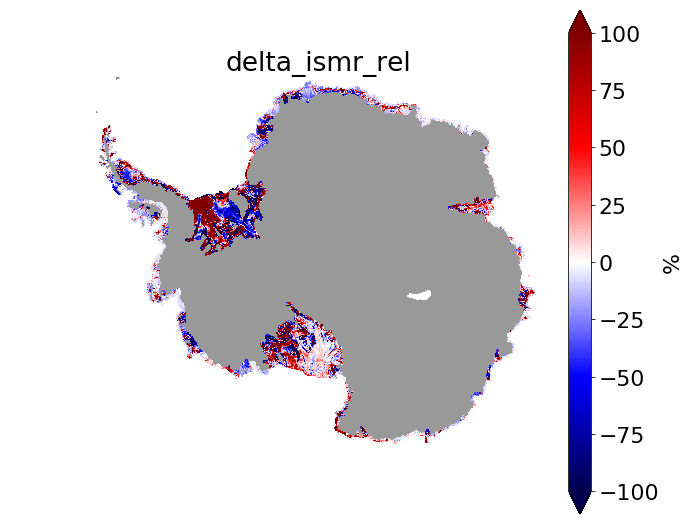

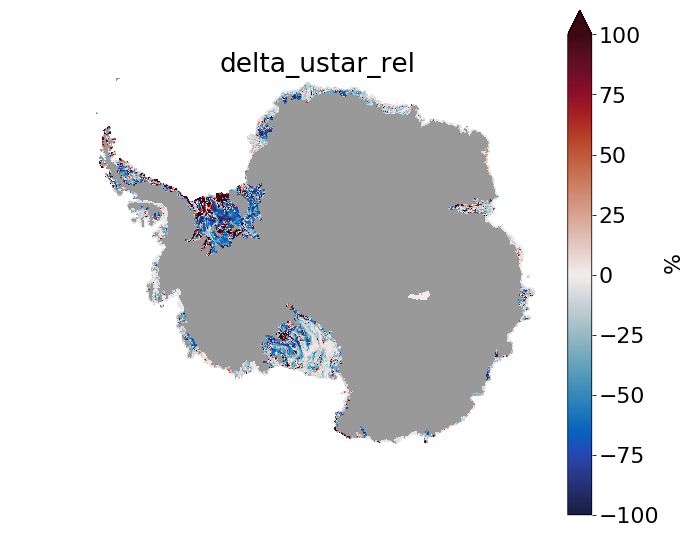

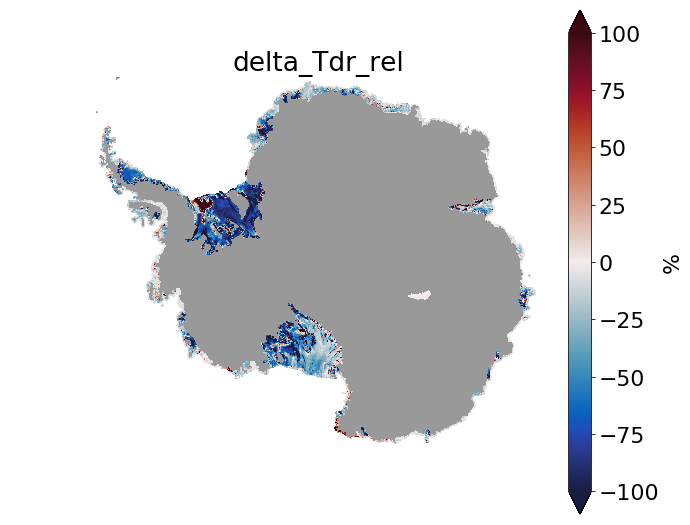

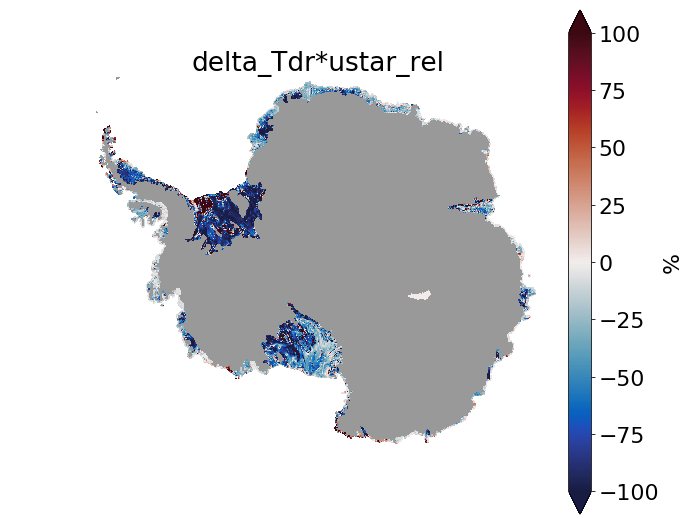

In [95]:
v_range=(-100,100)
for da,title,cbt,cmap,vrange in zip([(tides.m-no_tides.m)/no_tides.m*100,
                                     (ustar-ustar_nt)/ustar_nt*100,
                                     (Tdr-Tdr_nt)/Tdr_nt*100,
                                     (Tdr*ustar-Tdr_nt*ustar_nt)/(Tdr_nt*ustar_nt)*100],
                             ['delta_ismr_rel','delta_ustar_rel','delta_Tdr_rel','delta_Tdr*ustar_rel'],
                             ['%','%','%','%'],
                             [plt.cm.seismic,ocm.balance,ocm.balance,ocm.balance],
                             [v_range,v_range,v_range,v_range]):
    plot_map(da,grd,title,cbt,cmap,vrange)

In [99]:
shelves_path = os.path.join(proj_dir,'data','analysis','interim','shelves4.npy')
shelves = np.load(shelves_path).item()

In [225]:
def equip_shelves(shelves,grd):
    for k,v in log_progress(shelves.items(),every=2):
        dA = 1/(grd.pm.where(v['mask'])*grd.pn)
        shelves[k]['dA']=dA
        shelves[k]['weights']=dA/dA.sum()
        shelves[k]['A']=dA.sum().values*10**-9
    return shelves

distributed.nanny - WARNING - Worker process 3176 was killed by unknown signal
distributed.nanny - WARNING - Worker process 3178 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 3184 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 3187 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker


In [119]:
big_shelves = {k: v for k, v in shelves.items() if v['mask'].any() and shelves[k]["A"]>5}

In [224]:
big_shelves2 = {k: v for k, v in shelves2.items() if v['mask'].any() and v["A"]>5}

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 3117 was killed by unknown signal
distributed.nanny 

In [227]:
big_shelves2 = equip_shelves(big_shelves2,grd2)

<IPython.core.display.Javascript object>


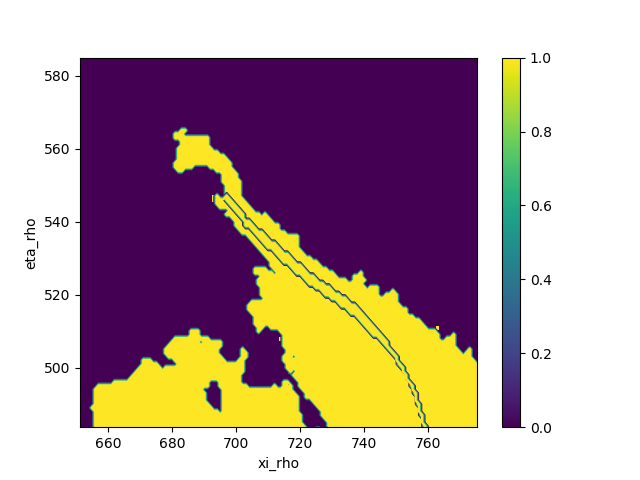

In [114]:
%matplotlib notebook
plt.close()
fig,ax = plt.subplots()
mask.plot()
for key,data in log_progress(big_shelves.items(),every=2):
    ax.contour(data['mask'])
plt.show()

In [131]:
def make_avg(quant,name,shelves_dict):
    for k,v in log_progress(shelves_dict.items(),every=2):
        shelves_dict[k][name]=(quant*v['weights']).sum().values
    return shelves_dict

for d4,name in zip([tides.m,ustar,Tdr,Tdr*ustar],
                   ['m','ustar','Tdr','TdrUstar']):
    big_shelves = make_avg(d4,name,big_shelves)
    
for d4,name in zip([no_tides.m,ustar_nt,Tdr_nt,Tdr_nt*ustar_nt],
                   ['m_nt','ustar_nt','Tdr_nt','TdrUstar_nt']):
    big_shelves = make_avg(d4,name,big_shelves)

for d4,name in zip([tides.m-no_tides.m,ustar-ustar_nt,Tdr-Tdr_nt,Tdr*ustar-Tdr_nt*ustar_nt],
                   ['dm','dustar','dTdr','dTdrUstar']):
    big_shelves = make_avg(d4,name,big_shelves)

In [228]:
for d4,name in zip([m2,ustar2,Tdr2,Tdr2*ustar2],
                   ['m2','ustar2','Tdr2','TdrUstar2']):
    big_shelves2 = make_avg(d4,name,big_shelves2)

for k,v in big_shelves2.items():
    for name in ['m','ustar','Tdr','TdrUstar']:
        big_shelves2[k]['d'+name+'2'] = big_shelves[k][name] - big_shelves2[k][name+'2'] 

In [125]:
def make_avg_map(name):
    shelf_map = np.zeros_like(grd.mask_rho)
    for k,v in big_shelves.items():
        shelf_map[v['mask']]=v[name]
        
    return xr.DataArray(shelf_map,dims=('eta_rho','xi_rho')).where(mask)

avg_map={}
for name in ['dm','dustar','dTdr','dTdrUstar']:
    avg_map[name] = make_avg_map(name)

In [129]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
def plot_avg_map(da,grd,title,cbar_label,cmap,vrange):
    plt.close()
    fig,ax = plt.subplots(figsize=(10,8))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=-2*std
        vmax=+2*std
    else:
        vmin,vmax=vrange
    da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,cbar_kwargs={'label': cbar_label})
    ax.set_title(title)
    ax.set_ylim([250/2,2500/2])
    ax.set_xlim([200/2,2900/2])
    ax.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,'tmp','tidal_melting_'+title.replace('/','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")
    plt.show()

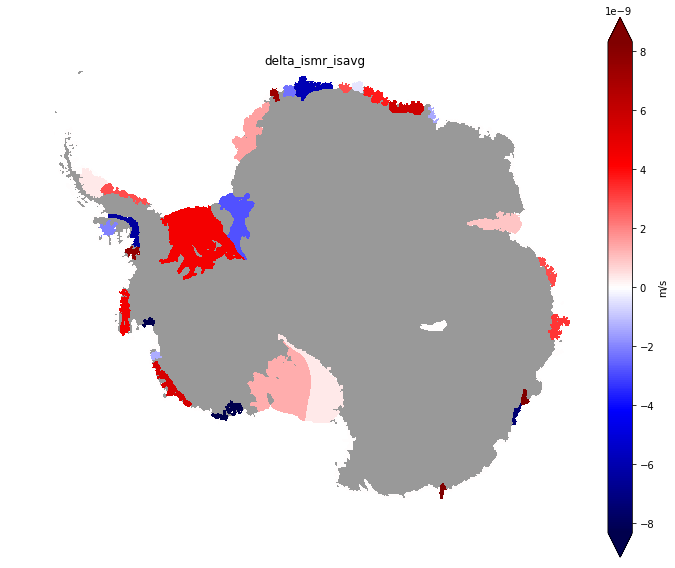

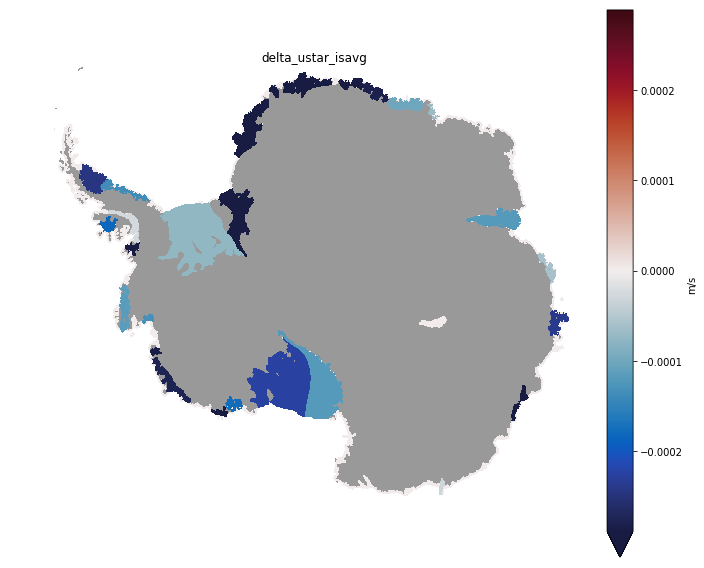

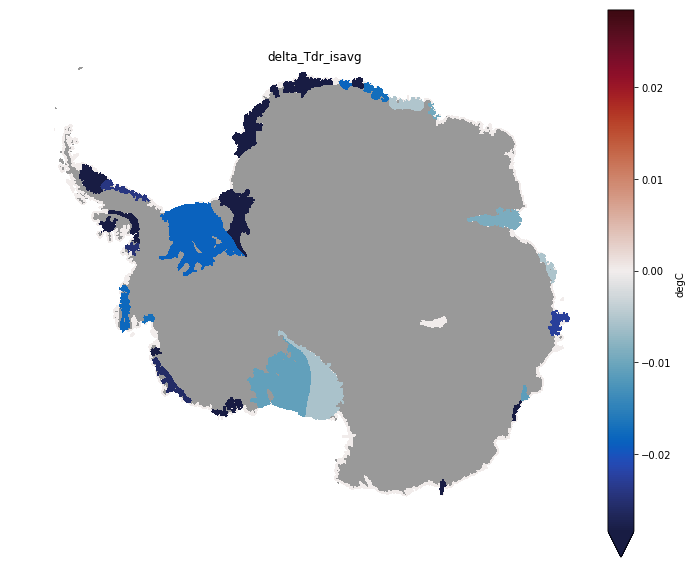

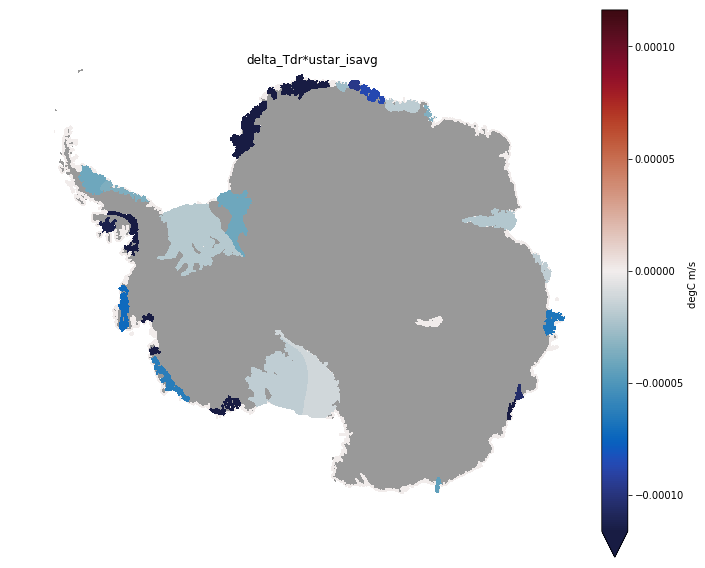

In [130]:
%matplotlib inline
for da,title,cbt,cmap,vrange in zip([avg_map['dm'],avg_map['dustar'],avg_map['dTdr'],avg_map['dTdrUstar']],
                             ['delta_ismr_isavg','delta_ustar_isavg','delta_Tdr_isavg','delta_Tdr*ustar_isavg'],
                             ['m/s','m/s','degC','degC m/s'],
                             [plt.cm.seismic,ocm.balance,ocm.balance,ocm.balance],
                             [None,None,None,None]):
    plot_map(da,grd,title,cbt,cmap,vrange)

In [156]:
def find_sector(shelves_dict,sector_dict):
    for key_shelf,data_shelf in shelves_dict.items():
        mask_shelf = data_shelf['mask']
        nb_shelf = np.count_nonzero(mask_shelf)
        for key_sec,mask_sec in sector_dict.items():
            nb_overlap = np.count_nonzero(mask_sec & mask_shelf)
            if nb_shelf-nb_overlap < (nb_shelf/2):
                shelves_dict[key_shelf]['sector']=key_sec
                continue
    return shelves_dict

sector_masks_path = os.path.join(data_dir,'interim','mask_sector_4.npy') 
sector=np.load(sector_masks_path).item()

big_shelves = find_sector(big_shelves,sector)

In [229]:
big_shelves2 = find_sector(big_shelves2,sector2)

In [231]:
for k,v in big_shelves2.items():
    for name in ['m','ustar','Tdr','TdrUstar']:
        big_shelves[k]['d'+name+'2'] = v['d'+name+'2'] 
        big_shelves[k][name+'2'] = v[name+'2'] 

In [157]:
n = len(sector)-1
colors = iter(plt.cm.rainbow(np.linspace(0,1,n)))
seccol = {} 
for key,data in sector.items():
    if key == 'Total Antarctica': continue
    seccol[key] = next(colors)

In [235]:
matplotlib.rcParams.update({'font.size': 12}) 
def plot_shelves_avg(x_quant,y_quant,title,xlab,ylab,shelves_dict,pertubation):
    
    plt.close()
    fig,ax = plt.subplots(figsize=(12,10))

    for key,data in log_progress(shelves_dict.items(),every=2):
        
        c=seccol[data['sector']]
        
        x1=data[x_quant+pertubation]
        y1=data[y_quant+pertubation]
        
        ax.plot(x1,y1,'o',label=key,c=c)
        ax.annotate(key,(x1,y1),size='x-small')
        
        x2=data[x_quant]
        y2=data[y_quant]
        
        ax.plot(x2,y2,'o',c=c)
        ax.annotate("", xy=(x1,y1), xytext=(x2, y2),
                    arrowprops=dict(arrowstyle="->",color=c))
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title,fontsize=18)
     
    #plt.savefig(os.path.join(fig_dir,'tmp','shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")    
    plt.show()

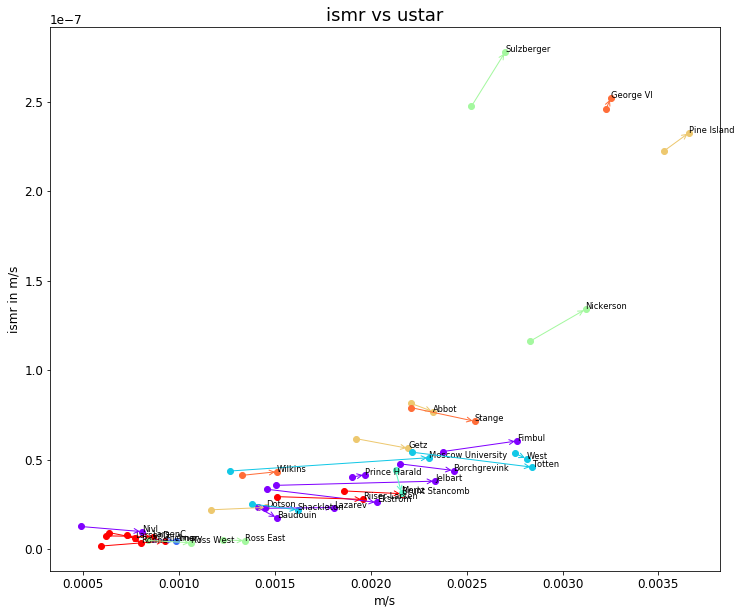

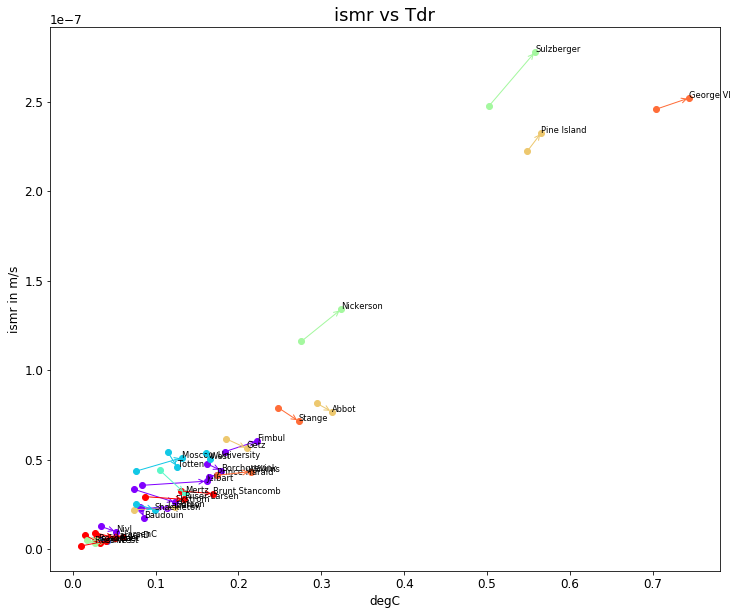

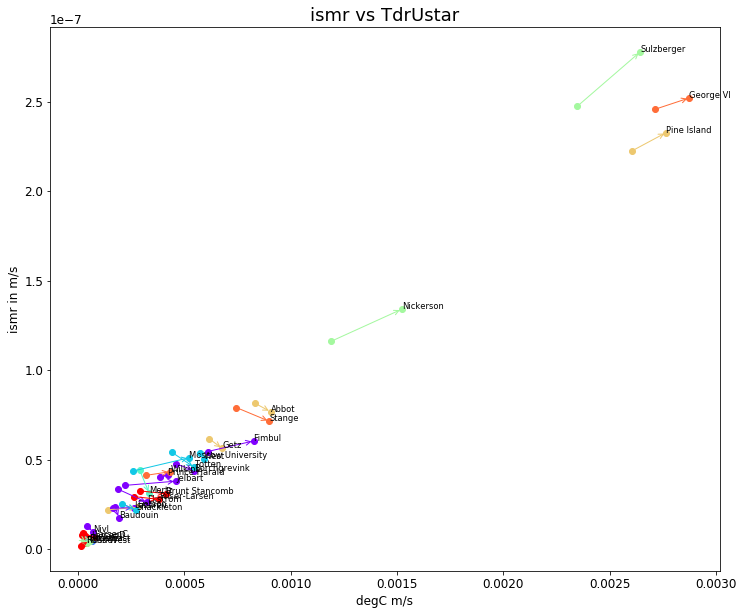

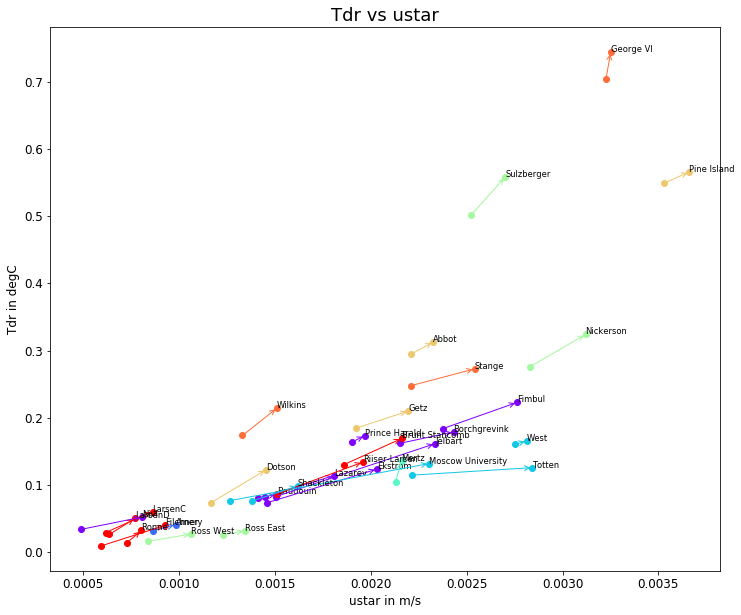

In [237]:
for quant,xlab in zip(['ustar','Tdr','TdrUstar'],
                      ['m/s','degC','degC m/s']):
    plot_shelves_avg(quant,'m','ismr vs '+quant,xlab,'ismr in m/s',big_shelves)
plot_shelves_avg('ustar','Tdr','Tdr vs ustar','ustar in m/s','Tdr in degC',big_shelves)

In [238]:
for quant,xlab in zip(['ustar','Tdr','TdrUstar'],
                      ['m/s','degC','degC m/s']):
    plot_shelves_avg(quant,'m','ismr vs '+quant,xlab,'ismr in m/s',big_shelves,'2')
plot_shelves_avg('ustar','Tdr','Tdr vs ustar','ustar in m/s','Tdr in degC',big_shelves,'2')

TypeError: plot_shelves_avg() takes 6 positional arguments but 7 were given

In [232]:
matplotlib.rcParams.update({'font.size': 12}) 
def plot_shelves_avg(x_quant,y_quant,title,xlab,ylab,shelves_dict):
    
    plt.close()
    fig,ax = plt.subplots(figsize=(12,10))

    for key,data in log_progress(shelves_dict.items(),every=2):
        
        c=seccol[data['sector']]
        
        x1=data[x_quant+'_nt']
        y1=data[y_quant+'_nt']
        
        ax.plot(x1,y1,'o',label=key,c=c)
        ax.annotate(key,(x1,y1),size='x-small')
        
        x2=data[x_quant]
        y2=data[y_quant]
        
        ax.plot(x2,y2,'o',c=c)
        ax.annotate("", xy=(x2,y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle="->",color=c))
        
        x3=data[x_quant+'2']
        y3=data[y_quant+'2']
        
        ax.plot(x3,y3,'o',c=c)
        ax.annotate("", xy=(x3,y3), xytext=(x2, y2),
                    arrowprops=dict(arrowstyle="->",color=c))
        #ax.annotate(key,(x,y),size='x-small')
        #ax.arrow(x1,y1,x2-x1,y2-y1,color='k')
        
        #x_all.append(x2)
        #y_all.append(y2)
    
    #x_all = np.array(x_all).squeeze()
    #y_all = np.array(y_all).squeeze()
    
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x_all, y_all)
    #ax.plot(x_all,slope*x_all+intercept,'gray',label='linear fit',alpha=0.3)
    #ax.text(0.1,0.9,"slope: %.2e    r-squared: %.2f" %(slope, r_value**2),transform=ax.transAxes,fontsize=18)
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title,fontsize=18)
     
    #plt.savefig(os.path.join(fig_dir,'tmp','shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")    
    plt.show()

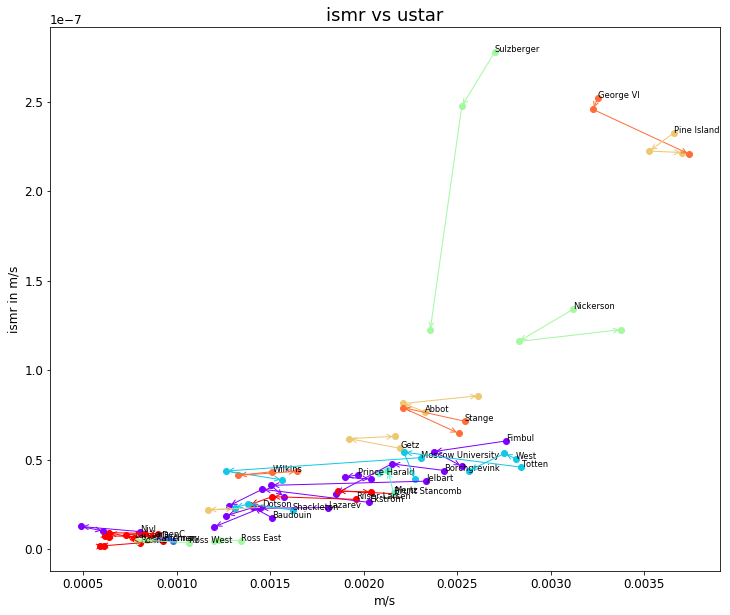

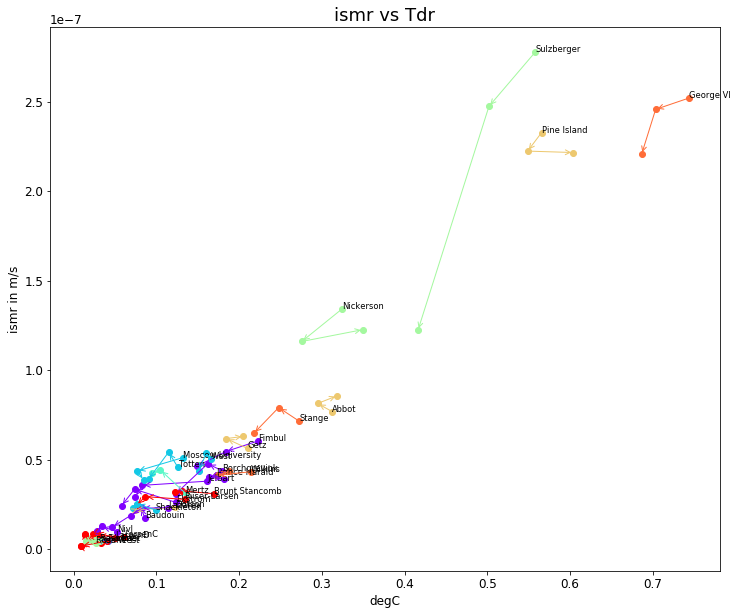

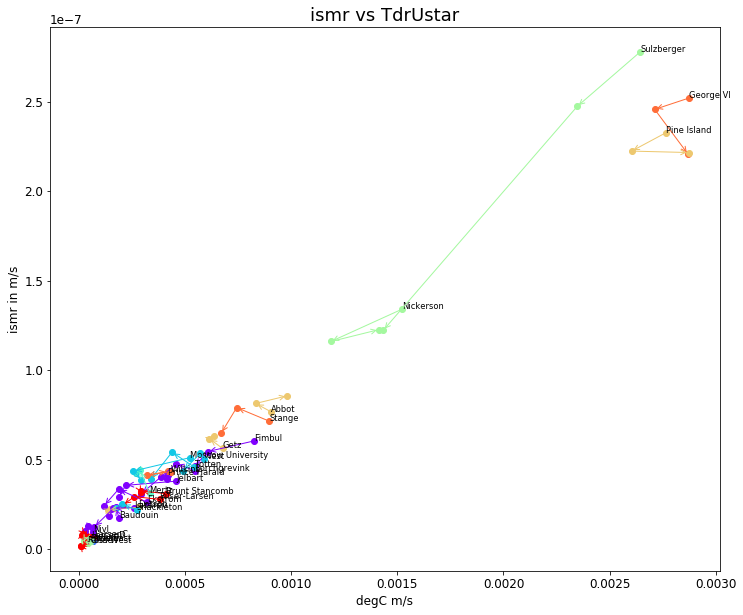

In [233]:
for quant,xlab in zip(['ustar','Tdr','TdrUstar'],
                      ['m/s','degC','degC m/s']):
    plot_shelves_avg(quant,'m','ismr vs '+quant,xlab,'ismr in m/s',big_shelves)

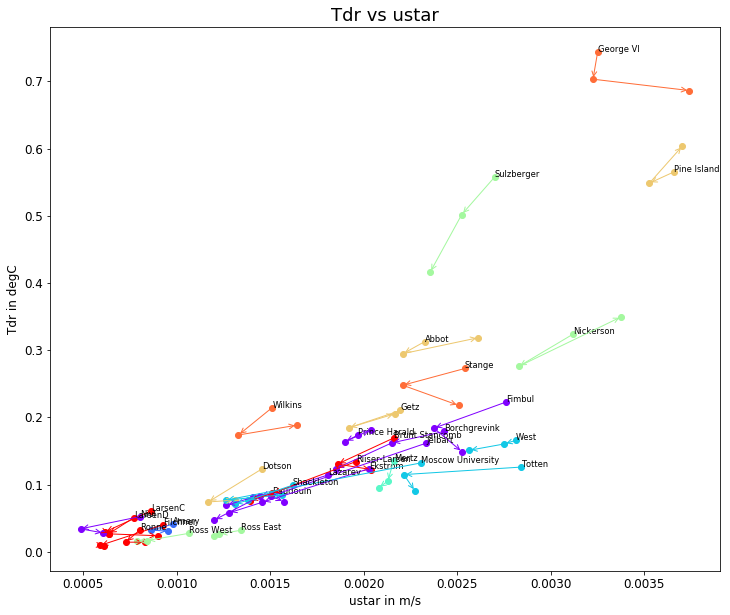

In [234]:
plot_shelves_avg('ustar','Tdr','Tdr vs ustar','ustar in m/s','Tdr in degC',big_shelves)

In [188]:
matplotlib.rcParams.update({'font.size': 12}) 
def plot_shelves_davg(x_quant,y_quant,title,xlab,ylab,shelves_dict):
    
    plt.close()
    fig,ax = plt.subplots(figsize=(12,10))
    
    x_all = []
    y_all = []

    for key,data in log_progress(shelves_dict.items(),every=2):
        
        c=seccol[data['sector']]
        
        x=data[x_quant]
        y=data[y_quant]
        
        ax.plot(x,y,'o',label=key,c=c)
        ax.annotate(key,(x,y),size='x-small')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title,fontsize=18)
     
    plt.savefig(os.path.join(fig_dir,'tmp','shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'),format='png',dpi=400,bbox_inches = "tight")    
    print(os.path.join(fig_dir,'tmp','shelfavg_'+title.replace('/','_').replace(' ','_')+'.png'))
    plt.show()

../../reports/figures/tmp/shelfavg__delta_ismr_vs_dustar.png


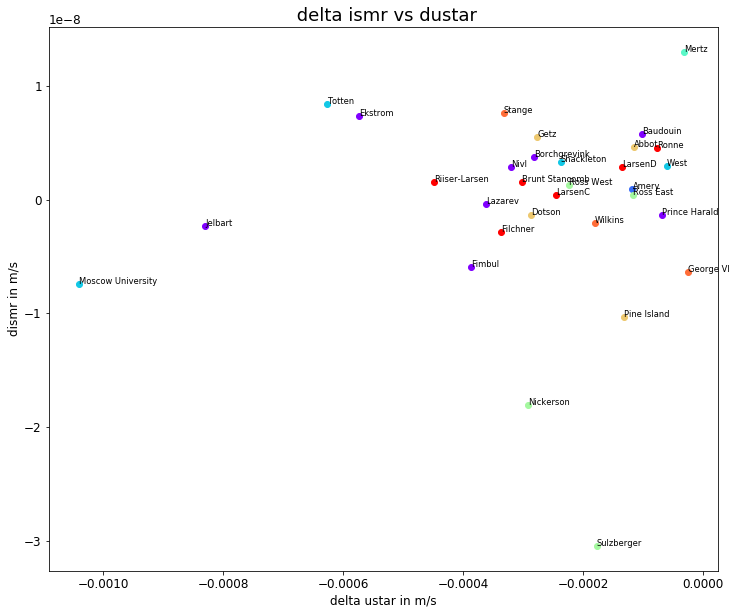

../../reports/figures/tmp/shelfavg__delta_ismr_vs_dTdr.png


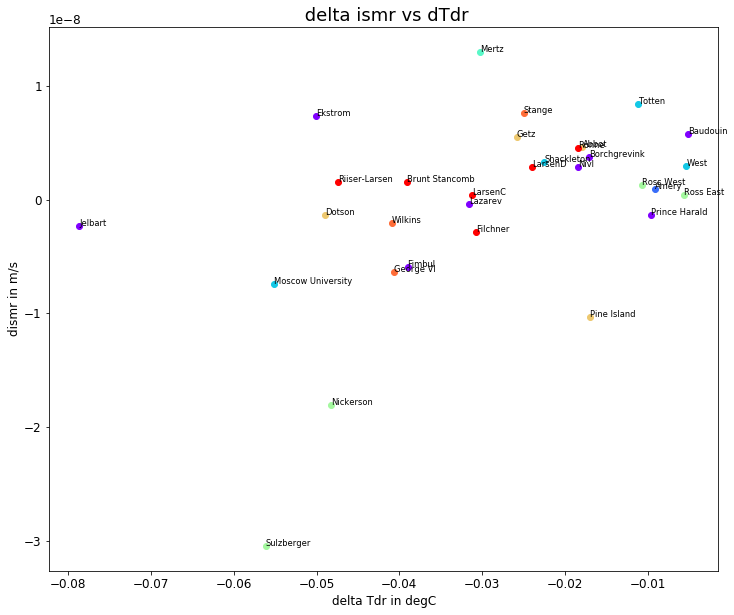

../../reports/figures/tmp/shelfavg__delta_ismr_vs_dTdrUstar.png


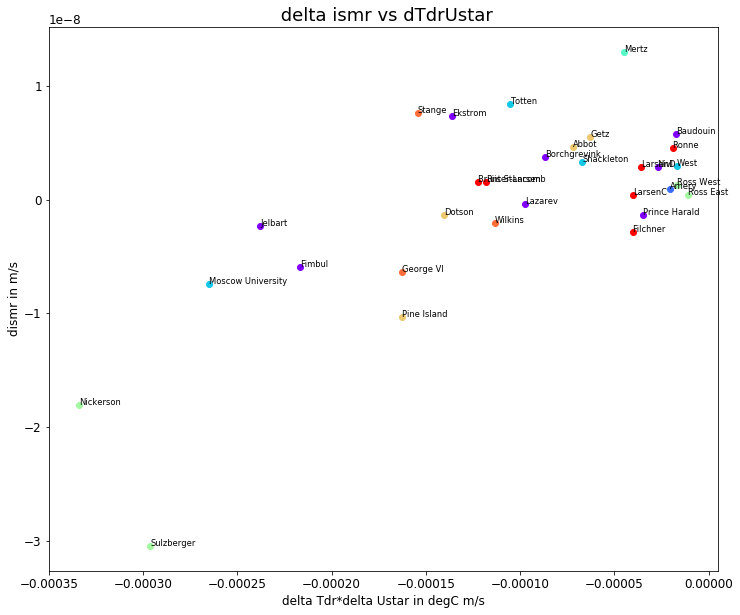

In [189]:
for quant,xlab in zip(['dustar','dTdr','dTdrUstar'],
                      ['delta ustar in m/s','delta Tdr in degC','delta Tdr*delta Ustar in degC m/s']):
    plot_shelves_davg(quant,'dm',' delta ismr vs '+quant,xlab,'dismr in m/s',big_shelves)

../../reports/figures/tmp/shelfavg_delta_Tdr_over_delta_ustar.png


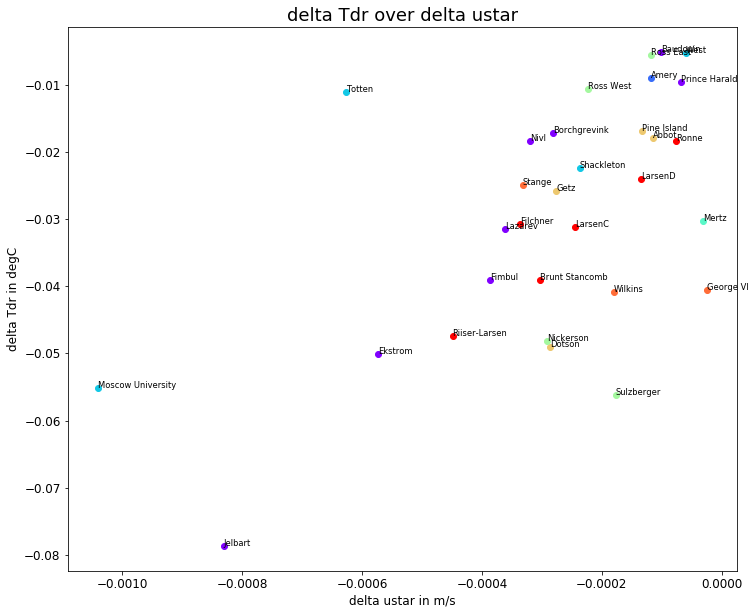

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:52670 remote=tcp://127.0.0.1:48331>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39978 remote=tcp://127.0.0.1:33269>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:52671 remote=tcp://127.0.0.1:48331>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39981 remote=tcp://127.0.0.1:33269>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39985 remote=tcp://127.0.0.1:33269>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39986 remote=tcp://127.0.0.1:33269>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:39987 remote=tcp://127.0.0.1:33269>


In [190]:
plot_shelves_davg('dustar','dTdr','delta Tdr over delta ustar','delta ustar in m/s','delta Tdr in degC',big_shelves)